## Bayesian optimization to infer Fractional Kelvin-Voigt model fitting parameters for the oscillation data of a chia gel

First, we are importing a variety of essential libraries that will help us with numerical computations, data manipulation, plotting, machine learning, Bayesian optimization, and other specialized tasks.

### Libraries:
- **NumPy (`numpy`)**: A fundamental package for numerical operations in Python.
- **Pandas (`pandas`)**: A powerful data manipulation and analysis library.
- **Matplotlib (`matplotlib.pyplot`)**: A plotting library used for creating static, animated, and interactive visualizations.
- **SciPy Special Functions (`scipy.special`)**: Specifically importing the gamma function for mathematical computations.
- **PyTorch (`torch`)**: A deep learning library for tensor computations and building neural networks.
- **BoTorch and GPyTorch**: Libraries for Gaussian Process Regression:
  - `SingleTaskGP`: For constructing Gaussian Process models.
  - `Standardize`: For standardizing outcomes.
  - `ExactMarginalLogLikelihood`: For exact marginal log likelihood calculation.
  - `fit_gpytorch_mll`: For fitting GP models.
- **Sobol Sequence (`sobol_seq`)**: For generating Sobol sequences for quasi-random sampling.
- **BoTorch Acquisition and Optimization**:
  - `qExpectedImprovement`: For Monte Carlo-based expected improvement.
  - `optimize_acqf`: For optimizing the acquisition function.
- **Scikit-Learn Preprocessing (`sklearn.preprocessing`)**: A collection of scalers for feature scaling, including:
  - `MinMaxScaler`
  - `RobustScaler`
  - `StandardScaler`
  - `MaxAbsScaler`
- **pyRheo (`pyRheo.oscillation_evaluator`)**: A custom library for evaluating properties in oscillation.
- **SciencePlots (`scienceplots`)**: A library to enhance Matplotlib plots with scientific visual styles.

These imports will provide all the necessary tools for the subsequent analysis and model building steps in this notebook.


In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import gamma
from scipy.optimize import minimize
import torch
import time as timer
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_mll
import sobol_seq
from botorch.acquisition.monte_carlo import qExpectedImprovement
from botorch.acquisition.logei import qLogExpectedImprovement, qLogNoisyExpectedImprovement
from botorch.acquisition.analytic import LogExpectedImprovement
from botorch.optim.optimize import optimize_acqf
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, MaxAbsScaler
from gpytorch.kernels import RBFKernel, MaternKernel, ScaleKernel, LinearKernel
from gpytorch.constraints import Interval
from pyRheo.oscillation_evaluator import OscillationEvaluator
import scienceplots
plt.style.use(['science', 'nature', 'retro'])

## Random Error Generation, Objective Function, Sobol Sampling and Model Initialization

In this section, we define various key functions and setup procedures required for our model analysis and optimization:



In [2]:
# Error function to add to the fractional rheology model
def createRandomError(n, std):
    return np.random.normal(loc=1, scale=std, size=n)

# Objective function to minimize (RRS weighted by true values)
def objective(params):
    logG, logV, alpha, beta = params
    G = 10 ** logG
    V = 10 ** logV
    params_no_scale = G, V, alpha, beta
    model = "FractionalKelvinVoigt"
    evaluator = OscillationEvaluator(model=model)
    # Compute oscillation data
    model_values = evaluator.compute_model(params_no_scale, omega) 
    # Add noise
    error = createRandomError(omega.shape[0], 0.00)
    model_values_noisy = np.multiply(model_values, error)
    # Define objective functions
    obj1 = np.sum(((G_prime - model_values_noisy[0]) / G_prime) ** 2) + np.sum(((G_double_prime - model_values_noisy[1]) / G_double_prime) ** 2)
    return -np.log10(obj1) # we take the negative because the EI by default maximizes and we are looking to minimize
    
# Function to create Sobol samples
def sobol_sample(space, n_samples):
    sobol_samples = sobol_seq.i4_sobol_generate(len(space), n_samples)
    sobol_scaled = sobol_samples * (space[:, 1] - space[:, 0]) + space[:, 0]
    return np.array(sobol_scaled)

# Initialize model function for single-objective problem
def initialize_model(train_x, train_obj):
    train_obj = train_obj.unsqueeze(-1)  # Add dimension for single task GP
    model = SingleTaskGP(train_x, train_obj, 
                         covar_module=ScaleKernel(MaternKernel(nu=1.5,
                                                   #ard_num_dims=4,
                                                   has_lengthscale=True,
                                                   lengthscale_constraint=Interval(0.01, 10),
                                                   outcome_transform=None, 
                                                   train_Yvar=None
                                                  )))
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    return mll, model

# Compute the qEI acquisition function to find new candidate points that maximize the objective
def compute_qei_acquisition_function(model, train_x, bounds):
    acq_func = qLogExpectedImprovement(
        model=model,
        best_f=train_x.max(),
    )
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=1,  # Number of candidates to generate in a batch
        num_restarts=10,
        raw_samples=10,
        options={"batch_limit": 5, "maxiter": 50},
    )
    return candidates

# Compute the qEI acquisition function to find new candidate points that maximize the objective
def compute_noisy_qei_acquisition_function(model, train_x, bounds):
    acq_func = qLogExpectedImprovement(
        model=model,
        best_f=train_x.max(),
    )
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=1,  # Number of candidates to generate in a batch
        num_restarts=5,
        raw_samples=50,
        options={"batch_limit": 5, "maxiter": 50},
    )
    return candidates

# Compute the EI acquisition function to find new candidate points that maximize the objective
def compute_ei_acquisition_function(model, train_x, bounds):
    acq_func = LogExpectedImprovement(
        model=model,
        best_f=train_x.max(),
    )
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=1,  # Number of candidates to generate in a batch
        num_restarts=10,
        raw_samples=10,
        options={"batch_limit": 5, "maxiter": 50},
    )
    return candidates

## Loading Rheological Data and Defining Search Space

In this section, we load the rheological data from a CSV file and define the search space bounds for our parameter optimization.

In [3]:
# Load rheological data
data = pd.read_csv('./data/chia_pudding/oscillation_chia_data.csv', delimiter=',', decimal=".")
omega = data['Angular Frequency'].values
G_prime = data['Storage Modulus'].values
G_double_prime = data['Loss Modulus'].values
y_true = np.concatenate([G_prime, G_double_prime])

# Define search space bounds
param_space = np.array([
    [0, 2],  # log10 scale for G
    [0, 2],  # log10 scale for V
    [0.5, 1],   # real scale for alpha
    [0, 0.5]   # real scale for beta
])

## Initial Sampling, Scaling, and Model Initialization

In this section, we conduct the initial exploration phase of our optimization process.


## Acquisition and Model Updating

In this section, we perform the exploitation phase of our optimization process. We iteratively generate new samples using the q-Expected Improvement (qEI) acquisition function, evaluate the objective function at these new sample points, and update our model accordingly.

### Iterative Optimization Process

For each iteration in the exploitation phase:
1. **Generate New Candidates**: We compute new candidate points using the qEI acquisition function.
2. **Evaluate Objective**: The objective function is evaluated at the new candidate points.
3. **Apply Scaling**: The new objective values are scaled using the previously defined MaxAbsScaler.
4. **Update Samples and Objectives**: The new sample and corresponding objective values (both original and scaled) are appended to the existing lists of samples and objective values. We also save the index of the new sample for tracking purposes.
5. **Update Tensors**: The updated samples and objective values are converted to tensors.
6. **Model Update**: The GP model is re-initialized and fitted using the updated data.
7. **Logging**: The iteration details, including the new sample and objective value, are printed.


In [4]:
# Assume these are defined correctly elsewhere in your code:
# - sobol_sample(param_space, n_initial_points)
# - objective(x)
# - initialize_model(X_samples_tensor, y_samples_tensor)
# - fit_gpytorch_mll(mll)
# - compute_ei_acquisition_function(model, y_samples_tensor, bounds)

# Store results from multiple runs
results = []
best_model = None
best_objective_value_overall = float('-inf')  # Looking for maximum, thus start very low
best_X_samples = None
best_y_samples = None

for run in range(5):
    print(f"Run {run + 1}/5")

    # Initial sampling using Sobol sequence
    n_initial_points = 8
    X_samples = sobol_sample(param_space, n_initial_points)
    y_samples = np.array([objective(x) for x in X_samples])

    # Apply MinMax scaling to the target values
    scaler = StandardScaler()
    y_samples_scaled = scaler.fit_transform(y_samples.reshape(-1, 1)).flatten()

    # Convert to tensors for BoTorch
    X_samples_tensor = torch.tensor(X_samples, dtype=torch.double)
    y_samples_tensor = torch.tensor(y_samples_scaled, dtype=torch.double)

    # Compute bounds for optimization
    bounds = torch.stack([
        torch.tensor(param_space[:, 0], dtype=torch.double),
        torch.tensor(param_space[:, 1], dtype=torch.double)
    ])

    # Initialize and fit the GP model
    mll, model = initialize_model(X_samples_tensor, y_samples_tensor)
    fit_gpytorch_mll(mll)

    # Access the lengthscale of the MaternKernel
    #lengthscale = model.covar_module.lengthscale

    # Print the lengthscale
    #print("Lengthscale:", lengthscale.item() if lengthscale.numel() == 1 else lengthscale)

    # Exploitation phase using qEI
    n_exploitation_iter = 200  # Number of iterations
    new_indices = []  # To keep track of new points added during exploitation
    objective_values = list(y_samples)  # Track original (not scaled) objective values

    # Initialize timing variables
    times_per_iteration = []
    cumulative_time = 0
    best_objective_value_run = float('-inf')  # Track best objective within this run

    # Stop condition parameters
    no_improvement_limit = 20  # Stop if no improvement after 50 iterations
    no_improvement_counter = 0
    tolerance = 1e-3  # Minimum improvement required to reset the counter

    for i in range(n_exploitation_iter):
        new_candidates = compute_qei_acquisition_function(model, y_samples_tensor, bounds)
        new_sample = new_candidates.detach().cpu().numpy().reshape(-1)
        new_sample_y = objective(new_sample)
        
        # Apply scaling to the new y value
        new_sample_y_scaled = scaler.transform(np.array([new_sample_y]).reshape(-1, 1)).flatten()[0]
        
        # Append the new sample to samples and objective values (original and scaled)
        new_indices.append(len(y_samples))  # Save the index of the new sample
        X_samples = np.vstack([X_samples, new_sample])
        y_samples = np.append(y_samples, new_sample_y)  # Original scale objective values
        y_samples_scaled = np.append(y_samples_scaled, new_sample_y_scaled)  # Scaled objective values
        
        # Update tensors
        X_samples_tensor = torch.tensor(X_samples, dtype=torch.double)
        y_samples_tensor = torch.tensor(y_samples_scaled, dtype=torch.double)

        # Append objective value to the list (original scale)
        objective_values.append(new_sample_y)
        
        # Update the model with the new data
        mll, model = initialize_model(X_samples_tensor, y_samples_tensor)
        start_time = timer.time()

        fit_gpytorch_mll(mll)
        
        # Record iteration time
        iteration_time = timer.time() - start_time
        times_per_iteration.append(iteration_time)
        cumulative_time += iteration_time

        print(f"Exploitation {i + 1}/{n_exploitation_iter} - New sample: {new_sample}, Objective value: {new_sample_y}")

        # Check stop condition based on no improvement with tolerance
        improvement = new_sample_y - best_objective_value_run
        if improvement > tolerance:
            best_objective_value_run = new_sample_y
            no_improvement_counter = 0
        else:
            no_improvement_counter += 1

        if no_improvement_counter >= no_improvement_limit:
            print(f"Stopping early due to no significant improvement (>{tolerance}) in the last {no_improvement_limit} iterations.")
            break
    
    # Update overall best model and save samples/data if new best result is found in this run
    if best_objective_value_run > best_objective_value_overall:
        best_objective_value_overall = best_objective_value_run
        best_model = model
        best_X_samples = X_samples
        best_y_samples = y_samples

    # Store relevant metrics for this run
    results.append({
        'objective_values': objective_values,
        #'lengthscale': lengthscale,
        'times_per_iteration': times_per_iteration,
        'cumulative_time': cumulative_time,
        'best_objective_value_run': best_objective_value_run
    })

# Display stored results for each run
for idx, res in enumerate(results):
    print(f"Results from Run {idx + 1}:")
    print("Objective values:", res['objective_values'])
    #print("Lengthscale:", res['lengthscale'].item())
    print("Best objective value in this run:", res['best_objective_value_run'])
    print("Total cumulative time:", res['cumulative_time'])
    print()

print("Overall best objective value:", best_objective_value_overall)
if best_model:
    #print("Best model lengthscale:", best_model.covar_module.lengthscale.item())
    print("Best X_samples from the best run:", best_X_samples)
    print("Best y_samples from the best run:", best_y_samples)
else:
    print("No best model found")

Run 1/5


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.0690], dtype=torch.float64), mean = tensor([-4.0246e-16], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluato

Exploitation 1/200 - New sample: [1.19225937 0.37246215 0.7655312  0.42921488], Objective value: -1.3195333338328106
Exploitation 2/200 - New sample: [1.11011563 0.28681541 0.60607813 0.47143308], Objective value: -1.385821157534185


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.9530], dtype=torch.float64), mean = tensor([0.1881], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 3/200 - New sample: [1.41964989 0.66799122 1.         0.12519043], Objective value: -1.2721566548885672


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.1800], dtype=torch.float64), mean = tensor([0.4055], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = O

Exploitation 4/200 - New sample: [1.70827145 0.45268013 0.7987472  0.22460457], Objective value: -0.5102766852037262
Exploitation 5/200 - New sample: [1.88025115 0.40988971 0.76484526 0.29120031], Objective value: -1.2115470168869253


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.0979], dtype=torch.float64), mean = tensor([0.4656], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 6/200 - New sample: [1.7245891  0.52586681 0.57889801 0.        ], Objective value: -1.3345027203951154


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.1499], dtype=torch.float64), mean = tensor([0.5819], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 7/200 - New sample: [1.69403457 0.24183106 1.         0.2821046 ], Objective value: -0.7370614768777919


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.1303], dtype=torch.float64), mean = tensor([0.5298], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 8/200 - New sample: [1.68304687 0.41671811 1.         0.5       ], Objective value: -1.690302651775651


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.1138], dtype=torch.float64), mean = tensor([0.5800], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 9/200 - New sample: [1.7268555  0.2408742  0.9359252  0.04647302], Objective value: -1.057769481963824


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.1530], dtype=torch.float64), mean = tensor([0.6748], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = O

Exploitation 10/200 - New sample: [1.68364728 0.13171487 0.74392695 0.22551809], Objective value: -0.707288171792925
Exploitation 11/200 - New sample: [1.66174556 0.         0.89242212 0.24528263], Objective value: -0.7409423846064058


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.1820], dtype=torch.float64), mean = tensor([0.8228], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 12/200 - New sample: [1.63282547 0.26892617 0.8026002  0.22897846], Objective value: -0.776800075670211


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.1888], dtype=torch.float64), mean = tensor([0.8868], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 13/200 - New sample: [1.82088677 0.06926302 0.85572103 0.26234693], Objective value: -0.7539714629225305


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.1682], dtype=torch.float64), mean = tensor([0.9159], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 14/200 - New sample: [1.66468464 0.05423503 0.77764563 0.37927422], Objective value: -1.0015697200251081


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.1597], dtype=torch.float64), mean = tensor([0.9588], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 15/200 - New sample: [1.75088892 0.         0.76097765 0.10864882], Objective value: -0.855919505135556


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.1783], dtype=torch.float64), mean = tensor([1.0240], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 16/200 - New sample: [1.69082451 0.14429022 0.89270577 0.21448149], Objective value: -0.6163890561026553


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2109], dtype=torch.float64), mean = tensor([1.0977], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 17/200 - New sample: [1.69801893 0.41318381 0.84297065 0.18777731], Objective value: -0.48289165934244194


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2424], dtype=torch.float64), mean = tensor([1.1700], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 18/200 - New sample: [1.70028417 0.46301615 0.84398495 0.18828455], Objective value: -0.4402179673912854


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2543], dtype=torch.float64), mean = tensor([1.2274], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 19/200 - New sample: [1.68050714 0.46518117 0.85682646 0.21417336], Objective value: -0.5395514227330421


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2766], dtype=torch.float64), mean = tensor([1.2914], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 20/200 - New sample: [1.71377046 0.46224146 0.81920939 0.15948568], Objective value: -0.42422897240856505


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.3168], dtype=torch.float64), mean = tensor([1.3662], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 21/200 - New sample: [1.73801358 0.46186223 0.84507806 0.16967234], Objective value: -0.2522815486893712


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2946], dtype=torch.float64), mean = tensor([1.3583], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 22/200 - New sample: [1.4579547  0.0768875  1.         0.20791842], Objective value: -1.1565643551128835


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.3753], dtype=torch.float64), mean = tensor([1.4518], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 23/200 - New sample: [1.77659482 0.48285689 0.88439344 0.14721988], Objective value: 0.05545666476086804


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4686], dtype=torch.float64), mean = tensor([1.5528], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 24/200 - New sample: [1.80539952 0.50263183 0.91462405 0.13191717], Objective value: 0.22082222256089062


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5129], dtype=torch.float64), mean = tensor([1.6305], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 25/200 - New sample: [1.82980066 0.53457651 0.94242677 0.11332428], Objective value: 0.0013218239157283909


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5894], dtype=torch.float64), mean = tensor([1.7255], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 26/200 - New sample: [1.81671752 0.47609232 0.92856583 0.13769915], Objective value: 0.2884983024283669


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6427], dtype=torch.float64), mean = tensor([1.8095], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 27/200 - New sample: [1.83405879 0.46554354 0.91625581 0.12370476], Objective value: 0.21287819382583417


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6744], dtype=torch.float64), mean = tensor([1.8806], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 28/200 - New sample: [1.82213235 0.47754763 0.93805527 0.16028929], Objective value: 0.09960548986083363


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6784], dtype=torch.float64), mean = tensor([1.9302], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = O

Exploitation 29/200 - New sample: [1.80023582 0.46914334 0.93454804 0.10916239], Objective value: -0.1541112198138979
Exploitation 30/200 - New sample: [1.85304628 0.50027022 0.89297383 0.14589404], Objective value: 0.1993760280730456


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7288], dtype=torch.float64), mean = tensor([2.0598], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 31/200 - New sample: [1.83272324 0.50754596 0.90260983 0.16297153], Objective value: 0.06521066018310256


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7259], dtype=torch.float64), mean = tensor([2.1006], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 32/200 - New sample: [1.89958651 0.47470874 0.91847444 0.1190322 ], Objective value: -0.16305331275977739


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7369], dtype=torch.float64), mean = tensor([2.1530], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 33/200 - New sample: [1.82875396 0.50785143 0.87208389 0.11334642], Objective value: 0.05203990329431394


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7181], dtype=torch.float64), mean = tensor([2.1672], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 34/200 - New sample: [1.83540199 0.68661085 0.90281801 0.16958851], Objective value: -0.5279310799667112


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6975], dtype=torch.float64), mean = tensor([2.1682], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 35/200 - New sample: [1.84261904 0.51884539 1.         0.20147657], Objective value: -0.7381449518919385


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7303], dtype=torch.float64), mean = tensor([2.2320], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 36/200 - New sample: [1.82771707 0.46820875 0.89429794 0.14495612], Objective value: 0.334057389984881


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7532], dtype=torch.float64), mean = tensor([2.2893], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 37/200 - New sample: [1.82986134 0.45432807 0.88575208 0.15010109], Objective value: 0.2703639472856536


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7801], dtype=torch.float64), mean = tensor([2.3489], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 38/200 - New sample: [1.82956303 0.4744203  0.89748096 0.14065756], Objective value: 0.35399417515629356


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8036], dtype=torch.float64), mean = tensor([2.4060], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 39/200 - New sample: [1.8269174  0.47509737 0.89971915 0.14121971], Objective value: 0.35576545133566717


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8244], dtype=torch.float64), mean = tensor([2.4609], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 40/200 - New sample: [1.82612435 0.48086054 0.9097227  0.13893987], Objective value: 0.35876370017543796


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8415], dtype=torch.float64), mean = tensor([2.5128], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 41/200 - New sample: [1.82045562 0.47835485 0.90726906 0.13955803], Objective value: 0.3448342693864276


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8263], dtype=torch.float64), mean = tensor([2.5292], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 42/200 - New sample: [1.8634524  0.4091015  0.80665904 0.11356492], Objective value: -0.3027546176862422


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8203], dtype=torch.float64), mean = tensor([2.5589], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 43/200 - New sample: [1.8295563  0.37857623 0.89199178 0.17455311], Objective value: -0.02767134428719161


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8237], dtype=torch.float64), mean = tensor([2.5974], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 44/200 - New sample: [1.81745562 0.46178928 0.85057735 0.15233696], Objective value: 0.17438001976780007


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8093], dtype=torch.float64), mean = tensor([2.6123], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 45/200 - New sample: [1.81423645 0.25944864 0.85183103 0.1955282 ], Objective value: -0.28321581059961826


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8227], dtype=torch.float64), mean = tensor([2.6575], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 46/200 - New sample: [1.83102259 0.48089858 0.90414202 0.13989172], Objective value: 0.3638541354881626


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8060], dtype=torch.float64), mean = tensor([2.6539], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 47/200 - New sample: [1.92154625 0.2672997  0.94674981 0.17985086], Objective value: -0.6407761954698139


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8177], dtype=torch.float64), mean = tensor([2.6965], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 48/200 - New sample: [1.83045162 0.48431739 0.90387907 0.1356148 ], Objective value: 0.35908459818822813


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8016], dtype=torch.float64), mean = tensor([2.6998], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 49/200 - New sample: [1.73659747 0.62829866 0.90402929 0.09529064], Objective value: -0.4758818448212901


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8121], dtype=torch.float64), mean = tensor([2.7403], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 50/200 - New sample: [1.83272876 0.47845398 0.90599129 0.13892848], Objective value: 0.3605860221198585


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8215], dtype=torch.float64), mean = tensor([2.7795], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 51/200 - New sample: [1.83016333 0.48108819 0.90165008 0.14040978], Objective value: 0.36404626672083057


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8295], dtype=torch.float64), mean = tensor([2.8173], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 52/200 - New sample: [1.83336432 0.48048122 0.90047121 0.13919141], Objective value: 0.3608154237350132


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8366], dtype=torch.float64), mean = tensor([2.8539], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 53/200 - New sample: [1.82950853 0.48034876 0.90365714 0.13869681], Objective value: 0.36338249196179795


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8429], dtype=torch.float64), mean = tensor([2.8894], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 54/200 - New sample: [1.83075677 0.48318267 0.90688281 0.13980705], Objective value: 0.36439586303925153


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8478], dtype=torch.float64), mean = tensor([2.9235], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 55/200 - New sample: [1.83089313 0.48593951 0.91337745 0.13682856], Objective value: 0.3569132019010401


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8466], dtype=torch.float64), mean = tensor([2.8957], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 56/200 - New sample: [1.91079487 0.66041786 0.90896328 0.02309703], Objective value: -1.1506116193908862


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8516], dtype=torch.float64), mean = tensor([2.9289], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 57/200 - New sample: [1.83011322 0.4819877  0.90554595 0.14011534], Objective value: 0.3644961501350268


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8558], dtype=torch.float64), mean = tensor([2.9611], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 58/200 - New sample: [1.83078544 0.48223176 0.9064706  0.13887943], Objective value: 0.3644742262918159


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8426], dtype=torch.float64), mean = tensor([2.9543], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 59/200 - New sample: [1.87441145 0.20908432 0.75910976 0.10608955], Objective value: -0.6219875982585137


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8288], dtype=torch.float64), mean = tensor([2.9523], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 60/200 - New sample: [1.69609506 0.69556034 0.77737133 0.21471643], Objective value: -0.5042685681210834


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8327], dtype=torch.float64), mean = tensor([2.9825], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 61/200 - New sample: [1.83040684 0.47976779 0.90435596 0.14204235], Objective value: 0.3593245115309727


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8361], dtype=torch.float64), mean = tensor([3.0121], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 62/200 - New sample: [1.8302443  0.48210744 0.90633823 0.13820104], Objective value: 0.36400016689408443


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8390], dtype=torch.float64), mean = tensor([3.0409], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 63/200 - New sample: [1.83259069 0.48309343 0.90615547 0.13852838], Objective value: 0.36384964021464794


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8322], dtype=torch.float64), mean = tensor([3.0587], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 64/200 - New sample: [1.7937533  0.59735922 0.78380995 0.1622341 ], Objective value: 0.07981277022189749


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8345], dtype=torch.float64), mean = tensor([3.0861], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 65/200 - New sample: [1.82924215 0.48338328 0.90502644 0.13898952], Objective value: 0.3660385871280607


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8362], dtype=torch.float64), mean = tensor([3.1127], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 66/200 - New sample: [1.82754219 0.48291995 0.89703293 0.14053608], Objective value: 0.36406575464512825


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8249], dtype=torch.float64), mean = tensor([3.1202], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 67/200 - New sample: [1.83387081 0.65713374 0.72930566 0.16819829], Objective value: -0.1690425716095461


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8258], dtype=torch.float64), mean = tensor([3.1453], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 68/200 - New sample: [1.83066097 0.47926351 0.89147965 0.13938751], Objective value: 0.352519233135596


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8138], dtype=torch.float64), mean = tensor([3.1449], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 69/200 - New sample: [1.76061973 0.59028196 0.69511522 0.2055325 ], Objective value: -0.38643756660191586


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8150], dtype=torch.float64), mean = tensor([3.1695], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 70/200 - New sample: [1.82810795 0.48395465 0.90194664 0.13970909], Objective value: 0.36694881473149926


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8042], dtype=torch.float64), mean = tensor([3.1760], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 71/200 - New sample: [1.76740245 0.63964918 0.76707968 0.114929  ], Objective value: -0.16580797018935267


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8052], dtype=torch.float64), mean = tensor([3.1996], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 72/200 - New sample: [1.82744145 0.48654541 0.90514413 0.13931796], Objective value: 0.3674371668330091


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7999], dtype=torch.float64), mean = tensor([3.1831], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 73/200 - New sample: [1.81447207 0.63757372 0.79480947 0.25090023], Objective value: -0.8706993135813091


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7916], dtype=torch.float64), mean = tensor([3.1943], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 74/200 - New sample: [1.82381154 0.55797968 0.75521377 0.13219543], Objective value: -0.006881592838176306


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7925], dtype=torch.float64), mean = tensor([3.2168], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 75/200 - New sample: [1.82738065 0.48527578 0.90311001 0.13973587], Objective value: 0.36746570010260304


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7930], dtype=torch.float64), mean = tensor([3.2388], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 76/200 - New sample: [1.82937449 0.48589579 0.90235244 0.13978935], Objective value: 0.3686425800212681


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7906], dtype=torch.float64), mean = tensor([3.2575], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 77/200 - New sample: [1.84185371 0.60442869 0.80405392 0.12951045], Objective value: 0.27670478757602285


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7901], dtype=torch.float64), mean = tensor([3.2779], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 78/200 - New sample: [1.81863623 0.58924184 0.82544469 0.12854106], Objective value: 0.3483685233421407


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7900], dtype=torch.float64), mean = tensor([3.2985], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 79/200 - New sample: [1.82974085 0.48688638 0.90110939 0.13961821], Objective value: 0.36961746672183776


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7918], dtype=torch.float64), mean = tensor([3.3206], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = O

Exploitation 80/200 - New sample: [1.82046165 0.60747267 0.82848135 0.13307611], Objective value: 0.43811609455054323
Exploitation 81/200 - New sample: [1.87790765 0.10588734 0.60166232 0.23140366], Objective value: -0.8121564833752907


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7884], dtype=torch.float64), mean = tensor([3.3274], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 82/200 - New sample: [1.8172461  0.61763133 0.83293807 0.12816621], Objective value: 0.43155837476365333


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7901], dtype=torch.float64), mean = tensor([3.3488], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 83/200 - New sample: [1.82284629 0.61131708 0.83862512 0.1357832 ], Objective value: 0.45095369846066147


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7916], dtype=torch.float64), mean = tensor([3.3697], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 84/200 - New sample: [1.82775057 0.61821188 0.83243818 0.13268765], Objective value: 0.44934746778930446


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7924], dtype=torch.float64), mean = tensor([3.3899], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 85/200 - New sample: [1.8246768  0.61666834 0.83093984 0.13716754], Objective value: 0.43723806520811503


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7925], dtype=torch.float64), mean = tensor([3.4092], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 86/200 - New sample: [1.83339406 0.61322327 0.8416825  0.13347695], Objective value: 0.423227893574853


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7933], dtype=torch.float64), mean = tensor([3.4289], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 87/200 - New sample: [1.82483166 0.61207645 0.83539715 0.13066997], Objective value: 0.4508458986105234


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7939], dtype=torch.float64), mean = tensor([3.4483], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 88/200 - New sample: [1.82375442 0.61359939 0.83645121 0.13225409], Objective value: 0.45721568162154813


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7942], dtype=torch.float64), mean = tensor([3.4672], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 89/200 - New sample: [1.82587542 0.61994986 0.84143539 0.12900324], Objective value: 0.4518708935436753


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7946], dtype=torch.float64), mean = tensor([3.4860], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 90/200 - New sample: [1.82319704 0.61641403 0.83914961 0.13232104], Objective value: 0.45995854006679304


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7944], dtype=torch.float64), mean = tensor([3.5040], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 91/200 - New sample: [1.81856478 0.61273721 0.84642879 0.1308633 ], Objective value: 0.4495456441916608


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7943], dtype=torch.float64), mean = tensor([3.5220], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 92/200 - New sample: [1.82128207 0.61787979 0.84193121 0.13370105], Objective value: 0.45801171081223524


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7938], dtype=torch.float64), mean = tensor([3.5393], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 93/200 - New sample: [1.81915512 0.62263167 0.84590152 0.13427003], Objective value: 0.44761397025991156


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7934], dtype=torch.float64), mean = tensor([3.5566], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 94/200 - New sample: [1.82205754 0.61611887 0.84098305 0.13194526], Objective value: 0.4597628455738898


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7916], dtype=torch.float64), mean = tensor([3.5722], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 95/200 - New sample: [1.80792335 0.60822434 0.84485997 0.13982282], Objective value: 0.4065629227426346


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7907], dtype=torch.float64), mean = tensor([3.5886], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 96/200 - New sample: [1.82621754 0.63341653 0.83689948 0.13240643], Objective value: 0.45198200398564553


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7890], dtype=torch.float64), mean = tensor([3.6039], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 97/200 - New sample: [1.83441362 0.63568846 0.83269569 0.12593453], Objective value: 0.41946747319549954


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7882], dtype=torch.float64), mean = tensor([3.6201], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 98/200 - New sample: [1.81942516 0.64098952 0.82819464 0.13383511], Objective value: 0.46475545718868466


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7872], dtype=torch.float64), mean = tensor([3.6358], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 99/200 - New sample: [1.81640818 0.64384623 0.83398929 0.13093483], Objective value: 0.4616022302085498


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7862], dtype=torch.float64), mean = tensor([3.6514], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 100/200 - New sample: [1.81786619 0.63802086 0.83242625 0.13288444], Objective value: 0.46511370543972885


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7850], dtype=torch.float64), mean = tensor([3.6667], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 101/200 - New sample: [1.81949063 0.64030155 0.82972955 0.129186  ], Objective value: 0.46622765878679817


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7839], dtype=torch.float64), mean = tensor([3.6818], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 102/200 - New sample: [1.81737177 0.64972721 0.82304997 0.13044477], Objective value: 0.47245954495047215


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7827], dtype=torch.float64), mean = tensor([3.6967], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 103/200 - New sample: [1.82229306 0.65559404 0.82337441 0.13022306], Objective value: 0.4702512644430121


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7812], dtype=torch.float64), mean = tensor([3.7112], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 104/200 - New sample: [1.81447296 0.65844283 0.82290801 0.13241704], Objective value: 0.4675556060554735


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7797], dtype=torch.float64), mean = tensor([3.7254], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 105/200 - New sample: [1.81860996 0.65232485 0.82573002 0.13272252], Objective value: 0.46722176340712274


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7779], dtype=torch.float64), mean = tensor([3.7392], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 106/200 - New sample: [1.80881213 0.76398876 0.76791211 0.1283928 ], Objective value: 0.45575472327364863


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7754], dtype=torch.float64), mean = tensor([3.7520], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 107/200 - New sample: [1.8164069  0.73275157 0.79001936 0.11759841], Objective value: 0.4265311804771261


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7701], dtype=torch.float64), mean = tensor([3.7606], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 108/200 - New sample: [1.79348294 0.77832708 0.78239863 0.10880614], Objective value: 0.24767165121683707


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7661], dtype=torch.float64), mean = tensor([3.7711], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 109/200 - New sample: [1.83220599 0.75306627 0.76436717 0.12935648], Objective value: 0.3369658960288062


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7625], dtype=torch.float64), mean = tensor([3.7819], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 110/200 - New sample: [1.79910657 0.74379725 0.77601438 0.13897031], Objective value: 0.3628994576458702


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7586], dtype=torch.float64), mean = tensor([3.7923], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 111/200 - New sample: [1.80339105 0.75385243 0.75368298 0.11597852], Objective value: 0.34779262145471407


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7566], dtype=torch.float64), mean = tensor([3.8048], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 112/200 - New sample: [1.8202875  0.6934387  0.80453801 0.12287503], Objective value: 0.4589300619489014


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7533], dtype=torch.float64), mean = tensor([3.8156], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 113/200 - New sample: [1.8179032  0.67089672 0.81554683 0.11825427], Objective value: 0.38191503850157965


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7475], dtype=torch.float64), mean = tensor([3.8220], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 114/200 - New sample: [1.80739358 0.78865451 0.7560129  0.14419892], Objective value: 0.19013354599972915


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7442], dtype=torch.float64), mean = tensor([3.8325], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 115/200 - New sample: [1.82523199 0.69034105 0.80355177 0.13666002], Objective value: 0.38633421717678873


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7418], dtype=torch.float64), mean = tensor([3.8441], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 116/200 - New sample: [1.81241122 0.70696941 0.8077086  0.12231986], Objective value: 0.44475132968830766


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7381], dtype=torch.float64), mean = tensor([3.8345], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 117/200 - New sample: [1.76258486 0.30013559 0.62888993 0.16019053], Objective value: -0.5691381236886006


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7343], dtype=torch.float64), mean = tensor([3.8438], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 118/200 - New sample: [1.83078585 0.7081258  0.8056106  0.11448195], Objective value: 0.34902876293899726


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7323], dtype=torch.float64), mean = tensor([3.8554], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 119/200 - New sample: [1.81135385 0.75729278 0.77754174 0.12438135], Objective value: 0.4646794158631908


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7300], dtype=torch.float64), mean = tensor([3.8665], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 120/200 - New sample: [1.81078923 0.69863116 0.79600848 0.12304219], Objective value: 0.4478259215075553


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7279], dtype=torch.float64), mean = tensor([3.8553], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 121/200 - New sample: [1.87664078 0.83421209 0.70447995 0.05844675], Objective value: -0.6531003293141782


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7260], dtype=torch.float64), mean = tensor([3.8666], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = O

Exploitation 122/200 - New sample: [1.82001966 0.65373906 0.81840401 0.13364501], Objective value: 0.4659073513372764
Stopping early due to no significant improvement (>0.001) in the last 20 iterations.
Run 2/5
Exploitation 1/200 - New sample: [1.1726984  0.23984294 0.53198591 0.34680923], Objective value: -1.3986146178598229


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.0003], dtype=torch.float64), mean = tensor([0.1490], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 2/200 - New sample: [1.38687717 0.65060147 0.96086992 0.23045241], Objective value: -1.2103616431625575


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.9744], dtype=torch.float64), mean = tensor([0.2157], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 3/200 - New sample: [1.69541222 0.48209927 0.96167279 0.        ], Objective value: -1.2512266516648975
Exploitation 4/200 - New sample: [1.45665231 0.63488129 0.68405291 0.05123899], Objective value: -1.2335656752197424


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.9516], dtype=torch.float64), mean = tensor([0.2751], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = O

Exploitation 5/200 - New sample: [1.62002769 0.46005775 0.81963862 0.34020152], Objective value: -0.9385673085485343
Exploitation 6/200 - New sample: [1.7181692  0.34582502 0.88219016 0.5       ], Objective value: -1.6736029942636967


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.0000], dtype=torch.float64), mean = tensor([0.4358], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 7/200 - New sample: [1.54926473 0.6041161  0.70135197 0.30219458], Objective value: -0.9134835490564572


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.0360], dtype=torch.float64), mean = tensor([0.5294], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 8/200 - New sample: [1.57928416 0.5286559  0.76759138 0.27043636], Objective value: -0.8446259859629484


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.0381], dtype=torch.float64), mean = tensor([0.5942], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 9/200 - New sample: [1.52499114 0.48415582 0.7381916  0.29877846], Objective value: -0.9613688072338649


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.0759], dtype=torch.float64), mean = tensor([0.6834], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 10/200 - New sample: [1.64221294 0.5792322  0.79890486 0.26637208], Objective value: -0.7408937461802514


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.1287], dtype=torch.float64), mean = tensor([0.7809], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 11/200 - New sample: [1.71997427 0.61115045 0.76345994 0.24630568], Objective value: -0.6109707303929248


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.1566], dtype=torch.float64), mean = tensor([0.8618], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 12/200 - New sample: [1.80041857 0.64347435 0.70792962 0.23392951], Objective value: -0.6645729326235912


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.1659], dtype=torch.float64), mean = tensor([0.9268], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 13/200 - New sample: [1.75674097 0.68066866 0.7932907  0.24707252], Objective value: -0.7309568144801395


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2086], dtype=torch.float64), mean = tensor([1.0136], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 14/200 - New sample: [1.74434646 0.56855383 0.72162324 0.22676032], Objective value: -0.4941362627935354


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2585], dtype=torch.float64), mean = tensor([1.1044], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 15/200 - New sample: [1.75975943 0.5129856  0.68509226 0.19873883], Objective value: -0.3922528897527233


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2928], dtype=torch.float64), mean = tensor([1.1851], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 16/200 - New sample: [1.78583978 0.4612643  0.61487572 0.1749527 ], Objective value: -0.4152332058179918


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.3381], dtype=torch.float64), mean = tensor([1.2720], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 17/200 - New sample: [1.79715086 0.47618692 0.68460168 0.1715574 ], Objective value: -0.29301694443011


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.3750], dtype=torch.float64), mean = tensor([1.3533], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 18/200 - New sample: [1.85256782 0.45557333 0.70273673 0.15061597], Objective value: -0.2821224150151042


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.3919], dtype=torch.float64), mean = tensor([1.4198], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 19/200 - New sample: [1.82040122 0.46938497 0.69686851 0.12403613], Objective value: -0.37369080258223875


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.3909], dtype=torch.float64), mean = tensor([1.4694], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 20/200 - New sample: [1.84498751 0.45033622 0.6993501  0.20044336], Objective value: -0.5053867375795563


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.3686], dtype=torch.float64), mean = tensor([1.4857], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 21/200 - New sample: [1.89588993 0.49450781 0.62385502 0.07630357], Objective value: -0.8412092806487647


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.3726], dtype=torch.float64), mean = tensor([1.5359], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 22/200 - New sample: [1.7646956  0.43254448 0.70617052 0.14660019], Objective value: -0.43452551720813215


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4086], dtype=torch.float64), mean = tensor([1.6084], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 23/200 - New sample: [1.80625572 0.50314654 0.73757941 0.1541049 ], Objective value: -0.1285728365656082


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4626], dtype=torch.float64), mean = tensor([1.6911], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 24/200 - New sample: [1.82609595 0.52066357 0.78173362 0.14908439], Objective value: 0.054887903174215324


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5047], dtype=torch.float64), mean = tensor([1.7673], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 25/200 - New sample: [1.8611331  0.52986394 0.8145234  0.14356292], Objective value: 0.0360061928065698


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5531], dtype=torch.float64), mean = tensor([1.8471], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 26/200 - New sample: [1.83218277 0.52727334 0.81122497 0.15168393], Objective value: 0.14188138444974205


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5814], dtype=torch.float64), mean = tensor([1.9147], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 27/200 - New sample: [1.82368964 0.51774184 0.83792118 0.1681511 ], Objective value: 0.03732003295966208


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6314], dtype=torch.float64), mean = tensor([1.9950], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 28/200 - New sample: [1.81893673 0.55397124 0.81934413 0.13483419], Objective value: 0.2682501328166941


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6611], dtype=torch.float64), mean = tensor([2.0631], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 29/200 - New sample: [1.8122461  0.57594325 0.8270278  0.11926309], Objective value: 0.15532387409077109


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6631], dtype=torch.float64), mean = tensor([2.1094], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 30/200 - New sample: [1.80780311 0.52923716 0.82335113 0.11178386], Objective value: -0.11381903821050614


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6820], dtype=torch.float64), mean = tensor([2.1684], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 31/200 - New sample: [1.83766796 0.5815458  0.82328075 0.15581597], Objective value: 0.11452629202652598


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6872], dtype=torch.float64), mean = tensor([2.2159], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 32/200 - New sample: [1.8806901  0.6063205  0.87020507 0.12020218], Objective value: -0.01726700094222142


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6964], dtype=torch.float64), mean = tensor([2.2658], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 33/200 - New sample: [1.84577181 0.59467318 0.79410925 0.11485151], Objective value: 0.057608461338353435


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7099], dtype=torch.float64), mean = tensor([2.3184], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 34/200 - New sample: [1.81792723 0.58094543 0.85629961 0.1601934 ], Objective value: 0.13918439286543477


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7290], dtype=torch.float64), mean = tensor([2.3745], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 35/200 - New sample: [1.8170422  0.571397   0.81625318 0.15264391], Objective value: 0.2392860310293675


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7416], dtype=torch.float64), mean = tensor([2.4252], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 36/200 - New sample: [1.8044988  0.56853879 0.81059687 0.15567845], Objective value: 0.1897123834072098


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7629], dtype=torch.float64), mean = tensor([2.4817], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 37/200 - New sample: [1.79724549 0.60384522 0.82889894 0.13643694], Objective value: 0.3299876360088849


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7643], dtype=torch.float64), mean = tensor([2.5218], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 38/200 - New sample: [1.7866702  0.63796088 0.84606715 0.11440712], Objective value: 0.08319739920353386


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7690], dtype=torch.float64), mean = tensor([2.5642], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 39/200 - New sample: [1.78125674 0.59587891 0.81344682 0.1385491 ], Objective value: 0.15412726074692415


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7859], dtype=torch.float64), mean = tensor([2.6156], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 40/200 - New sample: [1.8162508  0.61567435 0.83266474 0.14628335], Objective value: 0.35473533154136594


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7946], dtype=torch.float64), mean = tensor([2.6602], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 41/200 - New sample: [1.82359597 0.62811085 0.83336913 0.14903893], Objective value: 0.26646468510065674


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7960], dtype=torch.float64), mean = tensor([2.6978], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 42/200 - New sample: [1.80742321 0.61890337 0.85503141 0.15569624], Objective value: 0.16416438537653524


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7886], dtype=torch.float64), mean = tensor([2.7251], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 43/200 - New sample: [1.86580983 0.70030949 0.83369188 0.10509653], Objective value: -0.007787448644721256


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8045], dtype=torch.float64), mean = tensor([2.7731], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 44/200 - New sample: [1.81816211 0.6256529  0.81469428 0.13714257], Objective value: 0.4284464252868674


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8137], dtype=torch.float64), mean = tensor([2.8157], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 45/200 - New sample: [1.81296655 0.64743784 0.79322759 0.12630223], Objective value: 0.3541237073118243


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8034], dtype=torch.float64), mean = tensor([2.7943], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 46/200 - New sample: [1.7841903  0.73576923 0.72817142 0.03008376], Objective value: -0.948950177637626


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8135], dtype=torch.float64), mean = tensor([2.8363], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 47/200 - New sample: [1.82423981 0.64077419 0.80751211 0.14063702], Objective value: 0.38260019533001216


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8254], dtype=torch.float64), mean = tensor([2.8792], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 48/200 - New sample: [1.818004   0.63508628 0.81190034 0.13018199], Objective value: 0.4350474534994389


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8351], dtype=torch.float64), mean = tensor([2.9201], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 49/200 - New sample: [1.82194602 0.63761813 0.81519047 0.12590315], Objective value: 0.42346998268741065


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8433], dtype=torch.float64), mean = tensor([2.9593], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 50/200 - New sample: [1.81338486 0.63140129 0.81143361 0.13099643], Objective value: 0.41789811058115034


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8502], dtype=torch.float64), mean = tensor([2.9970], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 51/200 - New sample: [1.81480527 0.63100411 0.81266646 0.12950832], Objective value: 0.4161423063138879


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8562], dtype=torch.float64), mean = tensor([3.0336], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 52/200 - New sample: [1.82350501 0.63183663 0.80872293 0.12936356], Objective value: 0.4158785391820845


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8625], dtype=torch.float64), mean = tensor([3.0700], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 53/200 - New sample: [1.81817757 0.62186059 0.82250205 0.13127229], Objective value: 0.44180756400856863


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8528], dtype=torch.float64), mean = tensor([3.0516], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 54/200 - New sample: [1.87203079 0.67465172 0.99187577 0.07522599], Objective value: -0.8462617720343675


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8585], dtype=torch.float64), mean = tensor([3.0864], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 55/200 - New sample: [1.81489476 0.6279529  0.82457638 0.12931311], Objective value: 0.43834669879046867


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8619], dtype=torch.float64), mean = tensor([3.1189], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 56/200 - New sample: [1.82764399 0.65633696 0.81087044 0.12196801], Objective value: 0.4064805803893813


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8661], dtype=torch.float64), mean = tensor([3.1516], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 57/200 - New sample: [1.81441267 0.62281808 0.82191785 0.13267459], Objective value: 0.4384237208999725


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8699], dtype=torch.float64), mean = tensor([3.1837], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 58/200 - New sample: [1.81842105 0.62673517 0.82119218 0.13122458], Objective value: 0.44797304305277863


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8734], dtype=torch.float64), mean = tensor([3.2151], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 59/200 - New sample: [1.81920616 0.62791787 0.82170466 0.13130523], Objective value: 0.4522815161085976


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8767], dtype=torch.float64), mean = tensor([3.2460], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 60/200 - New sample: [1.81330394 0.65722033 0.81272774 0.13036835], Objective value: 0.46571787065132575


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8797], dtype=torch.float64), mean = tensor([3.2762], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 61/200 - New sample: [1.81158592 0.6703347  0.8118246  0.13151687], Objective value: 0.4711108398792407


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8664], dtype=torch.float64), mean = tensor([3.2716], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 62/200 - New sample: [1.92890115 0.47909005 0.92017198 0.13520716], Objective value: -0.44952177488762546


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8691], dtype=torch.float64), mean = tensor([3.3006], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 63/200 - New sample: [1.81319513 0.66658145 0.81713202 0.12985124], Objective value: 0.4719275518099029


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8712], dtype=torch.float64), mean = tensor([3.3288], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 64/200 - New sample: [1.81371116 0.66525797 0.81337967 0.1330588 ], Objective value: 0.4700315716480279


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8725], dtype=torch.float64), mean = tensor([3.3558], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 65/200 - New sample: [1.80953733 0.66577125 0.8139321  0.12924187], Objective value: 0.4594986575003469


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8740], dtype=torch.float64), mean = tensor([3.3827], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 66/200 - New sample: [1.8175297  0.67307145 0.81425242 0.12999547], Objective value: 0.4771886968074369


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8737], dtype=torch.float64), mean = tensor([3.4076], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 67/200 - New sample: [1.81426543 0.68125554 0.81670281 0.13465115], Objective value: 0.4401369419271818


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8761], dtype=torch.float64), mean = tensor([3.3805], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 68/200 - New sample: [2.         0.56651837 0.83176486 0.06418543], Objective value: -1.0696102170607038


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8771], dtype=torch.float64), mean = tensor([3.4061], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 69/200 - New sample: [1.81880115 0.67378716 0.80811432 0.12876359], Objective value: 0.4777802339429781


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8778], dtype=torch.float64), mean = tensor([3.4310], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 70/200 - New sample: [1.81766905 0.67016424 0.81221284 0.12968503], Objective value: 0.47850733974615994


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8781], dtype=torch.float64), mean = tensor([3.4552], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 71/200 - New sample: [1.81641055 0.67250714 0.8112584  0.12729322], Objective value: 0.4737860410172048


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8780], dtype=torch.float64), mean = tensor([3.4787], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 72/200 - New sample: [1.81817108 0.67313209 0.80901172 0.13146818], Objective value: 0.47537553451463166


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8778], dtype=torch.float64), mean = tensor([3.5018], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 73/200 - New sample: [1.81837641 0.68365752 0.80050328 0.12919925], Objective value: 0.4773684904820368


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8773], dtype=torch.float64), mean = tensor([3.5244], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 74/200 - New sample: [1.81727308 0.6795736  0.80437213 0.12910362], Objective value: 0.4790903934149148


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8763], dtype=torch.float64), mean = tensor([3.5461], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 75/200 - New sample: [1.82274423 0.68080461 0.80202202 0.12861712], Objective value: 0.46960919877675233


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8750], dtype=torch.float64), mean = tensor([3.5673], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 76/200 - New sample: [1.8154296  0.67892038 0.79985944 0.13217755], Objective value: 0.47074508263189224


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8736], dtype=torch.float64), mean = tensor([3.5881], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 77/200 - New sample: [1.81583329 0.68321523 0.80382593 0.12595887], Objective value: 0.47101353501064136


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8716], dtype=torch.float64), mean = tensor([3.6079], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 78/200 - New sample: [1.81837832 0.69848699 0.79466295 0.13302091], Objective value: 0.4557958674129471


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8684], dtype=torch.float64), mean = tensor([3.6261], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 79/200 - New sample: [1.7965351  0.70414081 0.79372708 0.13336166], Objective value: 0.4169695089249255


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8665], dtype=torch.float64), mean = tensor([3.6455], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 80/200 - New sample: [1.81312739 0.68934595 0.79997508 0.13241433], Objective value: 0.4714544612650764


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8643], dtype=torch.float64), mean = tensor([3.6641], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 81/200 - New sample: [1.81186399 0.69039374 0.79020227 0.12826015], Objective value: 0.4624495219334317


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8620], dtype=torch.float64), mean = tensor([3.6826], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 82/200 - New sample: [1.81312881 0.69672336 0.79929895 0.12486822], Objective value: 0.4689663516035212


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8598], dtype=torch.float64), mean = tensor([3.7008], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 83/200 - New sample: [1.81414529 0.71770268 0.79047713 0.12397337], Objective value: 0.4741826714906095


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8565], dtype=torch.float64), mean = tensor([3.7176], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 84/200 - New sample: [1.79820636 0.74484724 0.7831931  0.12568414], Objective value: 0.43686766943029004


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8529], dtype=torch.float64), mean = tensor([3.7337], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 85/200 - New sample: [1.81177321 0.73605628 0.7952606  0.13017383], Objective value: 0.42755437782821015


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8503], dtype=torch.float64), mean = tensor([3.7507], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 86/200 - New sample: [1.80972023 0.72646651 0.77604348 0.12853168], Objective value: 0.47222873432055024


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8472], dtype=torch.float64), mean = tensor([3.7669], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 87/200 - New sample: [1.80616727 0.72253768 0.78347592 0.12360966], Objective value: 0.45376126592435295


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8431], dtype=torch.float64), mean = tensor([3.7816], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 88/200 - New sample: [1.81811045 0.74612382 0.7693071  0.13257536], Objective value: 0.41257003352915916


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8382], dtype=torch.float64), mean = tensor([3.7951], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 89/200 - New sample: [1.80380367 0.7331951  0.77640178 0.13920999], Objective value: 0.3769096255574458


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8343], dtype=torch.float64), mean = tensor([3.8095], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = O

Exploitation 90/200 - New sample: [1.82055113 0.72720047 0.77501039 0.11935173], Objective value: 0.4244699823412569
Stopping early due to no significant improvement (>0.001) in the last 20 iterations.
Run 3/5
Exploitation 1/200 - New sample: [1.29913092 0.19853656 0.85804057 0.3877323 ], Objective value: -1.2589316474557417
Exploitation 2/200 - New sample: [1.63194    0.03311455 0.55198706 0.29512594], Objective value: -0.8640824616884573


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.1321], dtype=torch.float64), mean = tensor([0.2745], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = O

Exploitation 3/200 - New sample: [1.89365938 0.10498375 0.66872784 0.26710427], Objective value: -1.066623436858318
Exploitation 4/200 - New sample: [1.70627197 0.         0.5        0.5       ], Objective value: -1.517351826487689


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.0717], dtype=torch.float64), mean = tensor([0.3583], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = O

Exploitation 5/200 - New sample: [1.78142281 0.02714818 0.94798727 0.        ], Objective value: -1.3791422988369706
Exploitation 6/200 - New sample: [1.74957638 0.36355547 0.5        0.        ], Objective value: -1.3904431048382728


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.9880], dtype=torch.float64), mean = tensor([0.3839], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = O

Exploitation 7/200 - New sample: [1.87734429 0.40761533 1.         0.5       ], Objective value: -2.1183789357751968
Exploitation 8/200 - New sample: [1.06580504 0.15914995 0.87124129 0.00691347], Objective value: -1.5455745344975185


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.0403], dtype=torch.float64), mean = tensor([0.3396], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 9/200 - New sample: [1.63322496 0.05961278 0.6277265  0.17240264], Objective value: -0.96066396628294


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.1115], dtype=torch.float64), mean = tensor([0.4494], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 10/200 - New sample: [1.72834271 0.01555286 0.54779387 0.19745883], Objective value: -0.6962518495267436


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.1625], dtype=torch.float64), mean = tensor([0.5479], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 11/200 - New sample: [1.7713621  0.         0.5        0.15592476], Objective value: -0.6942048692914453


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.1854], dtype=torch.float64), mean = tensor([0.6270], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 12/200 - New sample: [1.71110327 0.         0.5        0.18860295], Objective value: -0.7685963644924813


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2345], dtype=torch.float64), mean = tensor([0.7218], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 13/200 - New sample: [1.7926367  0.         0.55984682 0.17521298], Objective value: -0.5788920169874627


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2604], dtype=torch.float64), mean = tensor([0.8008], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 14/200 - New sample: [1.84015663 0.         0.58425323 0.13293864], Objective value: -0.6407458285723762


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2355], dtype=torch.float64), mean = tensor([0.7799], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 15/200 - New sample: [0.99361607 0.         0.5        0.5       ], Objective value: -1.4689210881192123


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2679], dtype=torch.float64), mean = tensor([0.8583], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 16/200 - New sample: [1.82375777 0.         0.55521924 0.20702008], Objective value: -0.5620619850537301


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2460], dtype=torch.float64), mean = tensor([0.8366], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 17/200 - New sample: [1.30219891 0.74660377 0.99802521 0.01568666], Objective value: -1.4711319987274165


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2218], dtype=torch.float64), mean = tensor([0.8463], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 18/200 - New sample: [1.33631803 0.65458273 0.65708542 0.33928669], Objective value: -1.1708636999123303


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2502], dtype=torch.float64), mean = tensor([0.9151], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 19/200 - New sample: [1.8427431  0.         0.53918037 0.18543843], Objective value: -0.5469275201130817


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2498], dtype=torch.float64), mean = tensor([0.9602], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 20/200 - New sample: [1.9114472  0.         0.5        0.18659187], Objective value: -0.7497610622670309


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2361], dtype=torch.float64), mean = tensor([0.9329], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 21/200 - New sample: [1.91301836 0.         0.5        0.        ], Objective value: -1.5277075130042261


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2583], dtype=torch.float64), mean = tensor([0.9929], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 22/200 - New sample: [1.83425804 0.         0.56480847 0.18574262], Objective value: -0.534335948306931


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2764], dtype=torch.float64), mean = tensor([1.0493], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 23/200 - New sample: [1.83141855 0.03481971 0.55596752 0.18293497], Objective value: -0.5310392928054621


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2907], dtype=torch.float64), mean = tensor([1.1021], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 24/200 - New sample: [1.83491359 0.0176637  0.559704   0.18159673], Objective value: -0.5323407317856939


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.3003], dtype=torch.float64), mean = tensor([1.1504], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 25/200 - New sample: [1.81832181 0.0557635  0.52555032 0.20020667], Objective value: -0.5495327739406817


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2848], dtype=torch.float64), mean = tensor([1.1322], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 26/200 - New sample: [1.08058631 0.59496656 0.9147923  0.47947136], Objective value: -1.3867540912059102


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2864], dtype=torch.float64), mean = tensor([1.1710], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 27/200 - New sample: [1.86041305 0.01827325 0.56451625 0.20611475], Objective value: -0.6291322450385466


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2943], dtype=torch.float64), mean = tensor([1.2143], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 28/200 - New sample: [1.82113082 0.02338542 0.54635555 0.18238197], Objective value: -0.5359450337765195


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.3001], dtype=torch.float64), mean = tensor([1.2551], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 29/200 - New sample: [1.80721447 0.06421559 0.5597128  0.1808899 ], Objective value: -0.538190057444005


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.3049], dtype=torch.float64), mean = tensor([1.2943], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 30/200 - New sample: [1.8178668  0.03551718 0.56596461 0.18012556], Objective value: -0.5311943782715232


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.3052], dtype=torch.float64), mean = tensor([1.3285], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 31/200 - New sample: [1.7769753  0.12408266 0.52053533 0.2062229 ], Objective value: -0.5753577740998721


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2954], dtype=torch.float64), mean = tensor([1.3499], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 32/200 - New sample: [1.68725315 0.19977574 0.5        0.25458017], Objective value: -0.7467231952415556


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2798], dtype=torch.float64), mean = tensor([1.3563], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 33/200 - New sample: [1.54753982 0.39313041 0.61150287 0.27857563], Objective value: -0.9687332863672201


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2649], dtype=torch.float64), mean = tensor([1.3494], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 34/200 - New sample: [1.39421631 0.37271446 0.5        0.4861451 ], Objective value: -1.1793091678904206


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2516], dtype=torch.float64), mean = tensor([1.3599], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 35/200 - New sample: [1.6753983  0.60338641 0.5        0.33385181], Objective value: -0.8961399252270532


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2492], dtype=torch.float64), mean = tensor([1.3862], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 36/200 - New sample: [1.77731321 0.08190022 0.52154776 0.23664174], Objective value: -0.6184270345610405


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2351], dtype=torch.float64), mean = tensor([1.3890], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 37/200 - New sample: [1.54339452 0.73632492 0.5        0.14695054], Objective value: -1.0068090547975126


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2370], dtype=torch.float64), mean = tensor([1.4180], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 38/200 - New sample: [1.82147415 0.05095132 0.54899244 0.17226032], Objective value: -0.5393763163227883


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2386], dtype=torch.float64), mean = tensor([1.4461], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 39/200 - New sample: [1.82638029 0.01203578 0.56090945 0.17985545], Objective value: -0.5320620469566985


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2395], dtype=torch.float64), mean = tensor([1.4731], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 40/200 - New sample: [1.81504034 0.09617554 0.5440382  0.18882333], Objective value: -0.5310001007280898


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2393], dtype=torch.float64), mean = tensor([1.4985], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 41/200 - New sample: [1.80502951 0.08688842 0.53669424 0.18690968], Objective value: -0.5411664515546284


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2286], dtype=torch.float64), mean = tensor([1.4888], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 42/200 - New sample: [1.58334333 0.86373707 0.5        0.4435727 ], Objective value: -1.200785752152622


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2288], dtype=torch.float64), mean = tensor([1.5133], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = O

Exploitation 43/200 - New sample: [1.8010367  0.1154371  0.56493858 0.1934853 ], Objective value: -0.5317241172878194
Stopping early due to no significant improvement (>0.001) in the last 20 iterations.
Run 4/5
Exploitation 1/200 - New sample: [1.53470433 0.19803892 0.53253725 0.08158143], Objective value: -1.2743261083402617
Exploitation 2/200 - New sample: [1.14714027 0.03581792 0.73753214 0.32191822], Objective value: -1.427166054591697


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.9562], dtype=torch.float64), mean = tensor([0.1883], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 3/200 - New sample: [1.68055025 0.41437066 1.         0.        ], Objective value: -1.2752680972635884


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.0088], dtype=torch.float64), mean = tensor([0.3130], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = O

Exploitation 4/200 - New sample: [1.5282834  0.61322623 0.77920627 0.29882798], Objective value: -0.9408369383822539
Exploitation 5/200 - New sample: [1.59114454 0.53663409 0.86962654 0.4890311 ], Objective value: -1.457815650921552


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.9688], dtype=torch.float64), mean = tensor([0.3900], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 6/200 - New sample: [1.47921023 0.68302443 0.68537009 0.12650114], Objective value: -1.0679411928809248


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.9573], dtype=torch.float64), mean = tensor([0.4448], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 7/200 - New sample: [1.39589823 0.71599911 0.87528348 0.18436193], Objective value: -1.1237410939286157


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.0353], dtype=torch.float64), mean = tensor([0.5612], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 8/200 - New sample: [1.65391414 0.58526616 0.67275651 0.16019175], Objective value: -0.7000373162389604


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.1856], dtype=torch.float64), mean = tensor([0.7147], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 9/200 - New sample: [1.77380873 0.59056917 0.62266377 0.15014546], Objective value: -0.3649942215681207


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2443], dtype=torch.float64), mean = tensor([0.8266], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 10/200 - New sample: [1.89129149 0.60922025 0.56185184 0.1355507 ], Objective value: -0.53667163916224


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4024], dtype=torch.float64), mean = tensor([0.9895], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 11/200 - New sample: [1.84333651 0.66226128 0.69057964 0.13834584], Objective value: -0.07437592411556077


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5097], dtype=torch.float64), mean = tensor([1.1337], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 12/200 - New sample: [1.86928062 0.72129971 0.74446913 0.13634085], Objective value: -0.09274281214746934


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5461], dtype=torch.float64), mean = tensor([1.2372], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 13/200 - New sample: [1.86808952 0.6577526  0.74307838 0.16233031], Objective value: -0.3124208917418872


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5498], dtype=torch.float64), mean = tensor([1.3128], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 14/200 - New sample: [1.84826052 0.76038136 0.69454027 0.07529123], Objective value: -0.4705112038473982


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5151], dtype=torch.float64), mean = tensor([1.3020], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 15/200 - New sample: [1.89695745 0.74252411 0.69880416 0.24758183], Objective value: -1.180526033312204


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5022], dtype=torch.float64), mean = tensor([1.3524], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 16/200 - New sample: [1.84102897 0.63494601 0.72938934 0.07105444], Objective value: -0.6210380823835295


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4919], dtype=torch.float64), mean = tensor([1.3021], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 17/200 - New sample: [1.99435943 0.62456958 0.70632201 0.        ], Objective value: -1.556028615482889


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5902], dtype=torch.float64), mean = tensor([1.4249], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 18/200 - New sample: [1.81788945 0.6980112  0.71638912 0.13991524], Objective value: 0.14759414464734655


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6660], dtype=torch.float64), mean = tensor([1.5378], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 19/200 - New sample: [1.78794744 0.70313439 0.7248635  0.1457426 ], Objective value: 0.1385948426608937


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7130], dtype=torch.float64), mean = tensor([1.6344], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 20/200 - New sample: [1.79553057 0.69978656 0.69735328 0.14501165], Objective value: 0.050484048200966795


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7840], dtype=torch.float64), mean = tensor([1.7448], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 21/200 - New sample: [1.80852063 0.70789097 0.74035724 0.1396579 ], Objective value: 0.2790689988085401


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8607], dtype=torch.float64), mean = tensor([1.8587], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 22/200 - New sample: [1.8028083  0.71967225 0.76593987 0.13588431], Objective value: 0.40565839708963125


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9183], dtype=torch.float64), mean = tensor([1.9623], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 23/200 - New sample: [1.79196624 0.73074961 0.79155086 0.13523257], Objective value: 0.3707121157231808


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9695], dtype=torch.float64), mean = tensor([2.0620], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 24/200 - New sample: [1.79793397 0.73063343 0.77115474 0.1232865 ], Objective value: 0.4011973091548848


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.0142], dtype=torch.float64), mean = tensor([2.1572], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 25/200 - New sample: [1.8000951  0.71561746 0.77833787 0.12620156], Objective value: 0.4221758844717546


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.0573], dtype=torch.float64), mean = tensor([2.2509], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 26/200 - New sample: [1.81006409 0.72283101 0.78058422 0.12830461], Objective value: 0.4762043323121664


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.0923], dtype=torch.float64), mean = tensor([2.3387], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 27/200 - New sample: [1.8189495  0.72684201 0.79056383 0.1242297 ], Objective value: 0.46758527057193544


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.1186], dtype=torch.float64), mean = tensor([2.4196], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 28/200 - New sample: [1.81579413 0.72479061 0.78549975 0.13284635], Objective value: 0.4407831081961259


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.1355], dtype=torch.float64), mean = tensor([2.4925], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 29/200 - New sample: [1.8136365  0.72533429 0.7869363  0.11552474], Objective value: 0.38835646708349136


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.1457], dtype=torch.float64), mean = tensor([2.5588], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 30/200 - New sample: [1.81527229 0.71366829 0.80645082 0.13793901], Objective value: 0.34694011591844376


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.1562], dtype=torch.float64), mean = tensor([2.6241], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 31/200 - New sample: [1.81745298 0.74203643 0.78600182 0.13366069], Objective value: 0.3842839214354476


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.1371], dtype=torch.float64), mean = tensor([2.6546], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 32/200 - New sample: [1.80297496 0.76400102 0.84778595 0.10133202], Objective value: -0.10425576412739507


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.1109], dtype=torch.float64), mean = tensor([2.6628], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 33/200 - New sample: [1.70683601 0.67658177 0.86171744 0.18328136], Objective value: -0.4355584088079173


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.1244], dtype=torch.float64), mean = tensor([2.7257], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 34/200 - New sample: [1.81694905 0.718569   0.77868395 0.13061773], Objective value: 0.46016072342721875


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.1361], dtype=torch.float64), mean = tensor([2.7861], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 35/200 - New sample: [1.81510818 0.69960562 0.79017988 0.13174283], Objective value: 0.469028903527737


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.1449], dtype=torch.float64), mean = tensor([2.8433], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 36/200 - New sample: [1.81412548 0.71054948 0.78152042 0.13205328], Objective value: 0.4603871715859479


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.1223], dtype=torch.float64), mean = tensor([2.8566], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 37/200 - New sample: [1.69554716 0.83136484 0.75824063 0.14153728], Objective value: -0.2606340801795748


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.1300], dtype=torch.float64), mean = tensor([2.9103], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 38/200 - New sample: [1.81767863 0.70846198 0.78325032 0.12744278], Objective value: 0.4698809077066193


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.1352], dtype=torch.float64), mean = tensor([2.9610], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 39/200 - New sample: [1.81268835 0.70378031 0.78158819 0.13243084], Objective value: 0.4568460061497272


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.1399], dtype=torch.float64), mean = tensor([3.0104], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 40/200 - New sample: [1.81956432 0.71153852 0.78557736 0.12783539], Objective value: 0.4706177728919539


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.1424], dtype=torch.float64), mean = tensor([3.0569], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 41/200 - New sample: [1.82269397 0.70701409 0.78496474 0.129004  ], Objective value: 0.45563348778067414


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.1451], dtype=torch.float64), mean = tensor([3.1029], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 42/200 - New sample: [1.81377129 0.71187367 0.78705328 0.12816286], Objective value: 0.47973495456809356


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.1373], dtype=torch.float64), mean = tensor([3.1368], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 43/200 - New sample: [1.78345428 0.76968322 0.76118691 0.1415144 ], Objective value: 0.2775048968361552


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.1382], dtype=torch.float64), mean = tensor([3.1792], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 44/200 - New sample: [1.81350285 0.70782881 0.78858693 0.12593072], Objective value: 0.4752334339067489


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.1385], dtype=torch.float64), mean = tensor([3.2202], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 45/200 - New sample: [1.81424296 0.71287585 0.78771555 0.12823989], Objective value: 0.48014743784188857


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.1207], dtype=torch.float64), mean = tensor([3.2341], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 46/200 - New sample: [1.73445163 0.73844314 0.77096267 0.14590652], Objective value: -0.05566497842686131


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.1188], dtype=torch.float64), mean = tensor([3.2710], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 47/200 - New sample: [1.81054898 0.68330023 0.79296981 0.12676102], Objective value: 0.44522146339502144


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.1037], dtype=torch.float64), mean = tensor([3.2891], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 48/200 - New sample: [1.80569979 0.83591681 0.78646498 0.12853065], Objective value: 0.06506409066626359


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.0968], dtype=torch.float64), mean = tensor([3.3186], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 49/200 - New sample: [1.79556507 0.67084678 0.78712819 0.14274685], Objective value: 0.3323229281411239


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.0943], dtype=torch.float64), mean = tensor([3.3526], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 50/200 - New sample: [1.8203813  0.66758256 0.8157019  0.12417774], Objective value: 0.4547686171180625


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.0882], dtype=torch.float64), mean = tensor([3.3817], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 51/200 - New sample: [1.83191936 0.65475625 0.84738697 0.1236274 ], Objective value: 0.36987113950581657


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.0810], dtype=torch.float64), mean = tensor([3.4088], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 52/200 - New sample: [1.80291509 0.65883085 0.83217254 0.12219635], Objective value: 0.3459969709397101


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.0754], dtype=torch.float64), mean = tensor([3.4370], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 53/200 - New sample: [1.83117829 0.68620466 0.81665794 0.11918652], Objective value: 0.393295299732497


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.0696], dtype=torch.float64), mean = tensor([3.4644], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 54/200 - New sample: [1.8254524  0.65281178 0.81978908 0.13884749], Objective value: 0.39717948786945656


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.0666], dtype=torch.float64), mean = tensor([3.4944], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 55/200 - New sample: [1.81467483 0.71503995 0.78673864 0.1269749 ], Objective value: 0.48023975045899314


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.0633], dtype=torch.float64), mean = tensor([3.5235], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 56/200 - New sample: [1.8138736  0.7176346  0.78491367 0.12691845], Objective value: 0.47987286313098576


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.0521], dtype=torch.float64), mean = tensor([3.5412], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 57/200 - New sample: [1.83015563 0.63254756 0.82252345 0.11200244], Objective value: 0.21723809971497704


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.0370], dtype=torch.float64), mean = tensor([3.5483], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 58/200 - New sample: [1.85018947 0.61634939 0.90855428 0.13754237], Objective value: -0.04060106746322648


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.0328], dtype=torch.float64), mean = tensor([3.5744], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 59/200 - New sample: [1.81134304 0.67089119 0.80616276 0.13511922], Objective value: 0.45731497885125655


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.0287], dtype=torch.float64), mean = tensor([3.6001], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 60/200 - New sample: [1.82108277 0.67806315 0.80519575 0.13174099], Objective value: 0.467326906267833


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.0152], dtype=torch.float64), mean = tensor([3.6094], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 61/200 - New sample: [1.77702818 0.8544579  0.68653081 0.15227257], Objective value: 0.04987972872780821


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.0006], dtype=torch.float64), mean = tensor([3.6117], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = O

Exploitation 62/200 - New sample: [1.7772547  0.95935443 0.72962399 0.1302439 ], Objective value: -0.13160497125042572
Stopping early due to no significant improvement (>0.001) in the last 20 iterations.
Run 5/5
Exploitation 1/200 - New sample: [1.4025457  0.25746703 0.84505001 0.31964694], Objective value: -1.1590491856414842


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.0436], dtype=torch.float64), mean = tensor([0.2119], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = O

Exploitation 2/200 - New sample: [1.43297116 0.55348868 1.         0.31782427], Objective value: -1.2065441390474259
Exploitation 3/200 - New sample: [1.67967224 0.3245446  0.96480857 0.1347446 ], Objective value: -0.6722734863940909


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2943], dtype=torch.float64), mean = tensor([0.5905], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = O

Exploitation 4/200 - New sample: [1.86723018 0.21968023 1.         0.08504179], Objective value: -0.5902293983254908
Exploitation 5/200 - New sample: [1.99958073 0.20339235 1.         0.30776221], Objective value: -1.69383040563695


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2131], dtype=torch.float64), mean = tensor([0.5388], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = O

Exploitation 6/200 - New sample: [1.75561423 0.24857539 0.9949278  0.        ], Objective value: -1.3151635434102387
Exploitation 7/200 - New sample: [1.82224712 0.40947975 0.57516292 0.        ], Objective value: -1.3972029791686904


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.1296], dtype=torch.float64), mean = tensor([0.5304], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 8/200 - New sample: [1.5062112 0.        1.        0.       ], Objective value: -1.4233729296621718


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.0958], dtype=torch.float64), mean = tensor([0.5467], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = O

Exploitation 9/200 - New sample: [1.77573603 0.6141466  1.         0.        ], Objective value: -1.2802157644338719
Exploitation 10/200 - New sample: [1.70590769 0.         0.5        0.5       ], Objective value: -1.5164238269878982


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.1107], dtype=torch.float64), mean = tensor([0.6190], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 11/200 - New sample: [1.66077223 0.34526234 1.         0.14261593], Objective value: -0.7141803587794673


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.1407], dtype=torch.float64), mean = tensor([0.7004], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 12/200 - New sample: [1.66858456 0.35014003 1.         0.25562573], Objective value: -0.7227078553592795


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2080], dtype=torch.float64), mean = tensor([0.8035], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 13/200 - New sample: [1.70404373 0.33951616 0.89618763 0.21033692], Objective value: -0.4839614824304589


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.3278], dtype=torch.float64), mean = tensor([0.9338], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 14/200 - New sample: [1.76883392 0.31981652 0.9336136  0.18720675], Objective value: -0.17217092848946


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4575], dtype=torch.float64), mean = tensor([1.0723], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 15/200 - New sample: [1.80813616 0.33920537 0.94296605 0.17754507], Objective value: 0.002355875129784339


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5775], dtype=torch.float64), mean = tensor([1.2102], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 16/200 - New sample: [1.82752086 0.36686783 0.93037641 0.1667099 ], Objective value: 0.10395535593933695


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6581], dtype=torch.float64), mean = tensor([1.3310], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 17/200 - New sample: [1.84787796 0.35758718 0.90066895 0.15990221], Objective value: 0.044124831764235144


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6850], dtype=torch.float64), mean = tensor([1.4186], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 18/200 - New sample: [1.83425165 0.39630874 0.92331646 0.18680484], Objective value: -0.19512661976300746


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7571], dtype=torch.float64), mean = tensor([1.5337], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 19/200 - New sample: [1.83293469 0.34766937 0.92927251 0.13940851], Objective value: 0.1591999487556597


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8124], dtype=torch.float64), mean = tensor([1.6392], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 20/200 - New sample: [1.85557704 0.35496291 0.95094349 0.13219349], Objective value: 0.14451403446956915


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8605], dtype=torch.float64), mean = tensor([1.7399], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 21/200 - New sample: [1.83494105 0.36224942 0.93781588 0.13449796], Objective value: 0.17265440404246454


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8469], dtype=torch.float64), mean = tensor([1.7878], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 22/200 - New sample: [1.86429821 0.35936349 0.92143535 0.09715513], Objective value: -0.36313444842202963


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8898], dtype=torch.float64), mean = tensor([1.8818], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 23/200 - New sample: [1.84015001 0.35341946 0.94773489 0.14747015], Objective value: 0.2281881834115555


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9260], dtype=torch.float64), mean = tensor([1.9708], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 24/200 - New sample: [1.83322558 0.35262791 0.96701938 0.14312878], Objective value: 0.2374658287588074


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9524], dtype=torch.float64), mean = tensor([2.0521], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 25/200 - New sample: [1.8435227  0.34278897 0.96759459 0.1500072 ], Objective value: 0.20960628571549764


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9776], dtype=torch.float64), mean = tensor([2.1316], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 26/200 - New sample: [1.83673493 0.35871355 0.95997394 0.14617737], Objective value: 0.24768284127070048


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9948], dtype=torch.float64), mean = tensor([2.2039], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 27/200 - New sample: [1.8388914  0.36764447 0.98158706 0.14749802], Objective value: 0.21272877259276726


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.0114], dtype=torch.float64), mean = tensor([2.2747], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 28/200 - New sample: [1.82880915 0.36464191 0.96456699 0.14529539], Objective value: 0.24640620730165308


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.0240], dtype=torch.float64), mean = tensor([2.3411], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 29/200 - New sample: [1.83433517 0.36103142 0.96574016 0.14954025], Objective value: 0.23963330268443883


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.0035], dtype=torch.float64), mean = tensor([2.3683], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 30/200 - New sample: [1.82435396 0.24530575 0.82520143 0.18703417], Objective value: -0.2869197573546834


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9926], dtype=torch.float64), mean = tensor([2.4081], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 31/200 - New sample: [1.8563006  0.29974367 0.92347218 0.16723085], Objective value: -0.07418841069737446


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.0013], dtype=torch.float64), mean = tensor([2.4666], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 32/200 - New sample: [1.83435413 0.36321337 0.96354821 0.14127987], Objective value: 0.2445101961637151


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.0078], dtype=torch.float64), mean = tensor([2.5221], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 33/200 - New sample: [1.83019095 0.35933364 0.95814165 0.14409602], Objective value: 0.24340205595573652


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([2.0069], dtype=torch.float64), mean = tensor([2.5696], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 34/200 - New sample: [1.81805743 0.36685586 0.97784922 0.13772377], Objective value: 0.15599270080217992


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9991], dtype=torch.float64), mean = tensor([2.6083], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 35/200 - New sample: [1.86514944 0.35150755 1.         0.1479632 ], Objective value: 0.04666113723850554


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9828], dtype=torch.float64), mean = tensor([2.6336], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 36/200 - New sample: [1.79427746 0.3294184  0.84999854 0.15429088], Objective value: -0.15278098548293156


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9859], dtype=torch.float64), mean = tensor([2.6811], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 37/200 - New sample: [1.83485172 0.36526829 0.95991624 0.14577979], Objective value: 0.25441643261240343


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9876], dtype=torch.float64), mean = tensor([2.7264], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 38/200 - New sample: [1.83786921 0.37088187 0.96081874 0.14668948], Objective value: 0.25299249929080314


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9885], dtype=torch.float64), mean = tensor([2.7700], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 39/200 - New sample: [1.83500407 0.36801965 0.95789437 0.14665113], Objective value: 0.2559889573816859


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9880], dtype=torch.float64), mean = tensor([2.8114], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 40/200 - New sample: [1.83913271 0.3666696  0.95738133 0.14734941], Objective value: 0.24810625084775303


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9872], dtype=torch.float64), mean = tensor([2.8516], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 41/200 - New sample: [1.83250877 0.3711478  0.95902299 0.14523351], Objective value: 0.25914362153001574


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9760], dtype=torch.float64), mean = tensor([2.8785], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 42/200 - New sample: [1.84080184 0.4253485  1.         0.14338196], Objective value: 0.03105270729863313


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9743], dtype=torch.float64), mean = tensor([2.9158], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 43/200 - New sample: [1.83296094 0.37846053 0.96296119 0.14555844], Objective value: 0.25931625394721713


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9716], dtype=torch.float64), mean = tensor([2.9514], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 44/200 - New sample: [1.83627961 0.38325655 0.96847725 0.14279127], Objective value: 0.25213151437284687


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9686], dtype=torch.float64), mean = tensor([2.9859], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 45/200 - New sample: [1.83593473 0.37793867 0.96553823 0.14380314], Objective value: 0.25672575867484443


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9653], dtype=torch.float64), mean = tensor([3.0193], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 46/200 - New sample: [1.83292448 0.37580129 0.96053788 0.14409049], Objective value: 0.2613480470462201


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9486], dtype=torch.float64), mean = tensor([3.0087], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 47/200 - New sample: [1.69821952 0.23166726 0.72508756 0.22232497], Objective value: -0.6485988916582995


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9449], dtype=torch.float64), mean = tensor([3.0400], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 48/200 - New sample: [1.83032083 0.3832167  0.96155852 0.13982705], Objective value: 0.25094212819994466


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9415], dtype=torch.float64), mean = tensor([3.0709], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 49/200 - New sample: [1.83507476 0.37926457 0.95882749 0.1444405 ], Objective value: 0.26508030522648746


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9377], dtype=torch.float64), mean = tensor([3.1006], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 50/200 - New sample: [1.83720222 0.38363545 0.95907192 0.14536234], Objective value: 0.26339324771863604


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9336], dtype=torch.float64), mean = tensor([3.1294], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 51/200 - New sample: [1.83754223 0.38033069 0.95881408 0.14280071], Objective value: 0.26445697336351187


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9292], dtype=torch.float64), mean = tensor([3.1572], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 52/200 - New sample: [1.83488774 0.37989764 0.95708722 0.145114  ], Objective value: 0.26631181704475954


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9239], dtype=torch.float64), mean = tensor([3.1833], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 53/200 - New sample: [1.84449482 0.38660907 0.96185036 0.14415304], Objective value: 0.24535818382336286


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9085], dtype=torch.float64), mean = tensor([3.1783], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 54/200 - New sample: [1.73261388 0.14924232 0.90076684 0.21690373], Objective value: -0.4798319292165508


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9041], dtype=torch.float64), mean = tensor([3.2041], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 55/200 - New sample: [1.83424431 0.37962956 0.95592421 0.1451646 ], Objective value: 0.2670986862724588


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9029], dtype=torch.float64), mean = tensor([3.1753], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 56/200 - New sample: [1.72922801 0.22386904 0.83012508 0.36058461], Objective value: -1.066172867438998


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8987], dtype=torch.float64), mean = tensor([3.2003], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 57/200 - New sample: [1.83340317 0.38131846 0.95727671 0.14673826], Objective value: 0.2643983511974826


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8943], dtype=torch.float64), mean = tensor([3.2246], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 58/200 - New sample: [1.83498116 0.37890544 0.95494787 0.14399382], Objective value: 0.26742273824002466


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8898], dtype=torch.float64), mean = tensor([3.2481], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 59/200 - New sample: [1.83557216 0.37830783 0.95531051 0.14500676], Objective value: 0.2661769921128178


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8851], dtype=torch.float64), mean = tensor([3.2711], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 60/200 - New sample: [1.83481732 0.38142992 0.95526134 0.14359354], Objective value: 0.2690980984943492


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8762], dtype=torch.float64), mean = tensor([3.2546], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 61/200 - New sample: [1.78650763 0.08784951 0.77002216 0.10519242], Objective value: -0.7678099685131183


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8714], dtype=torch.float64), mean = tensor([3.2762], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 62/200 - New sample: [1.83134125 0.37912915 0.95203845 0.15067613], Objective value: 0.25277369059608173


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8669], dtype=torch.float64), mean = tensor([3.2979], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 63/200 - New sample: [1.83474688 0.38381003 0.95356147 0.14343629], Objective value: 0.27169713834995096


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8537], dtype=torch.float64), mean = tensor([3.2983], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 64/200 - New sample: [1.78122906 0.24163385 0.89197351 0.1448942 ], Objective value: -0.30303650276210514


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8495], dtype=torch.float64), mean = tensor([3.3193], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 65/200 - New sample: [1.83232878 0.39085244 0.95328452 0.14254428], Objective value: 0.27533587721686714


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8450], dtype=torch.float64), mean = tensor([3.3395], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 66/200 - New sample: [1.83102935 0.4019357  0.95402485 0.1398702 ], Objective value: 0.27342093253750477


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8406], dtype=torch.float64), mean = tensor([3.3594], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 67/200 - New sample: [1.83349543 0.39614957 0.95375185 0.14149024], Objective value: 0.2773365862175715


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8360], dtype=torch.float64), mean = tensor([3.3787], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 68/200 - New sample: [1.83189894 0.39598299 0.94930775 0.14010786], Objective value: 0.27538973161675523


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8312], dtype=torch.float64), mean = tensor([3.3974], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 69/200 - New sample: [1.83514846 0.39658325 0.9529145  0.13893393], Objective value: 0.2719734499299661


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8265], dtype=torch.float64), mean = tensor([3.4157], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 70/200 - New sample: [1.82982683 0.39640509 0.95324713 0.14265031], Objective value: 0.2761794918403758


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8218], dtype=torch.float64), mean = tensor([3.4337], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 71/200 - New sample: [1.83303227 0.39808448 0.95202399 0.1441356 ], Objective value: 0.28098207658686586


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8171], dtype=torch.float64), mean = tensor([3.4514], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 72/200 - New sample: [1.83410694 0.39928552 0.95022344 0.14410518], Objective value: 0.28321005829819407


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8125], dtype=torch.float64), mean = tensor([3.4688], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 73/200 - New sample: [1.83242017 0.40501146 0.94722163 0.14273391], Objective value: 0.2895900225928722


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8076], dtype=torch.float64), mean = tensor([3.4855], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 74/200 - New sample: [1.82732137 0.42354013 0.94271248 0.13714538], Objective value: 0.28069902310260864


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8030], dtype=torch.float64), mean = tensor([3.5022], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 75/200 - New sample: [1.83218505 0.41422686 0.94584895 0.14087435], Objective value: 0.29397692000380377


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7982], dtype=torch.float64), mean = tensor([3.5184], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 76/200 - New sample: [1.82746844 0.41339266 0.94388939 0.14084545], Objective value: 0.28849874120348407


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7935], dtype=torch.float64), mean = tensor([3.5343], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 77/200 - New sample: [1.83511489 0.41434095 0.94171965 0.13864942], Objective value: 0.29310430683983146


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7887], dtype=torch.float64), mean = tensor([3.5499], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 78/200 - New sample: [1.83583423 0.41746876 0.94687722 0.14011973], Objective value: 0.2929903895512919


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7839], dtype=torch.float64), mean = tensor([3.5649], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 79/200 - New sample: [1.83361521 0.41439931 0.94563508 0.13872129], Objective value: 0.2896572200251113


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7792], dtype=torch.float64), mean = tensor([3.5800], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 80/200 - New sample: [1.83437535 0.41703574 0.94313038 0.1425437 ], Objective value: 0.2990399139526544


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7719], dtype=torch.float64), mean = tensor([3.5906], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 81/200 - New sample: [1.8426397  0.55739693 0.8424059  0.1521152 ], Objective value: 0.16120579675677704


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7680], dtype=torch.float64), mean = tensor([3.6062], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 82/200 - New sample: [1.84287608 0.50122892 0.89965514 0.1382652 ], Objective value: 0.33809023488717543


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7646], dtype=torch.float64), mean = tensor([3.6219], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 83/200 - New sample: [1.82496569 0.4880409  0.88575964 0.14155697], Objective value: 0.3563442841761523


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7610], dtype=torch.float64), mean = tensor([3.6372], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 84/200 - New sample: [1.81339128 0.51269181 0.890486   0.14064234], Objective value: 0.3554272187185056


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7563], dtype=torch.float64), mean = tensor([3.6507], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 85/200 - New sample: [1.83276065 0.51170652 0.88775786 0.12578403], Objective value: 0.3029840837352641


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7522], dtype=torch.float64), mean = tensor([3.6650], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 86/200 - New sample: [1.82196181 0.4995619  0.89788865 0.1475019 ], Objective value: 0.3379133014638178


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7478], dtype=torch.float64), mean = tensor([3.6784], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 87/200 - New sample: [1.81736509 0.50934883 0.8701253  0.14920273], Objective value: 0.32028722857348785


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7435], dtype=torch.float64), mean = tensor([3.6918], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 88/200 - New sample: [1.82674231 0.47907268 0.90310681 0.13313926], Objective value: 0.328705494031326


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7379], dtype=torch.float64), mean = tensor([3.7029], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 89/200 - New sample: [1.80556528 0.49724906 0.88510951 0.13572096], Objective value: 0.25577079836808003


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7334], dtype=torch.float64), mean = tensor([3.7155], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 90/200 - New sample: [1.82347197 0.52466091 0.88940573 0.14892666], Objective value: 0.31932303003970447


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7293], dtype=torch.float64), mean = tensor([3.7284], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 91/200 - New sample: [1.83717039 0.48877376 0.88704453 0.14253958], Objective value: 0.33799574572055424


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7259], dtype=torch.float64), mean = tensor([3.7421], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 92/200 - New sample: [1.82424568 0.50644235 0.88832448 0.14145163], Objective value: 0.38082262598479927


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7174], dtype=torch.float64), mean = tensor([3.7435], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 93/200 - New sample: [1.7710957  0.59045881 0.8261324  0.17869471], Objective value: -0.08844563453063388


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7123], dtype=torch.float64), mean = tensor([3.7543], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 94/200 - New sample: [1.84719389 0.46961889 0.92800242 0.13831553], Objective value: 0.282881614658217


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7039], dtype=torch.float64), mean = tensor([3.7532], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 95/200 - New sample: [1.83515962 0.50841898 0.77283032 0.17473788], Objective value: -0.1829974517830255


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7007], dtype=torch.float64), mean = tensor([3.7661], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 96/200 - New sample: [1.82678897 0.50260003 0.88684875 0.14112531], Objective value: 0.3784556980247106


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7021], dtype=torch.float64), mean = tensor([3.7485], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 97/200 - New sample: [1.88268119 0.64150436 0.88333629 0.20070923], Objective value: -0.8512750737096311


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6960], dtype=torch.float64), mean = tensor([3.7565], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 98/200 - New sample: [1.8038391  0.54658671 0.84328897 0.12754058], Objective value: 0.18964031769243914


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6886], dtype=torch.float64), mean = tensor([3.7521], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 99/200 - New sample: [1.80934617 0.6102887  0.76040071 0.0950514 ], Objective value: -0.32320868016294274


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6844], dtype=torch.float64), mean = tensor([3.7414], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 100/200 - New sample: [1.677921   0.53709623 0.71329554 0.18486379], Objective value: -0.5848412294341083


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6816], dtype=torch.float64), mean = tensor([3.7539], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 101/200 - New sample: [1.82395859 0.508829   0.88534984 0.14204038], Objective value: 0.3801444063864594


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6768], dtype=torch.float64), mean = tensor([3.7634], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 102/200 - New sample: [1.82671272 0.50267468 0.93092515 0.13140325], Objective value: 0.26695807844315306


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6740], dtype=torch.float64), mean = tensor([3.7755], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 103/200 - New sample: [1.82580909 0.50779824 0.88881973 0.14097391], Objective value: 0.38389389255574247


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6699], dtype=torch.float64), mean = tensor([3.7856], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 104/200 - New sample: [1.83312102 0.45283842 0.90559726 0.13459954], Objective value: 0.3055704458415313


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6654], dtype=torch.float64), mean = tensor([3.7761], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 105/200 - New sample: [1.64274555 0.742541   0.74644306 0.16685468], Objective value: -0.5403537500929552


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6658], dtype=torch.float64), mean = tensor([3.7611], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 106/200 - New sample: [1.75371416 0.71519231 0.60276122 0.27066328], Objective value: -0.7947034206595519


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6631], dtype=torch.float64), mean = tensor([3.7726], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 107/200 - New sample: [1.82841345 0.50771847 0.88728179 0.14274709], Objective value: 0.3749217422127915


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6588], dtype=torch.float64), mean = tensor([3.7818], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 108/200 - New sample: [1.83850728 0.50206308 0.85417757 0.13733072], Objective value: 0.2796396563058987


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6561], dtype=torch.float64), mean = tensor([3.7931], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 109/200 - New sample: [1.82478961 0.50740096 0.89179692 0.13906513], Objective value: 0.38524594606540863


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6535], dtype=torch.float64), mean = tensor([3.8043], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 110/200 - New sample: [1.82436635 0.50911609 0.89212488 0.13937211], Objective value: 0.3857860245935495


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6594], dtype=torch.float64), mean = tensor([3.7853], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 111/200 - New sample: [1.48310913 0.72243406 0.65346943 0.31749873], Objective value: -0.991942703726725


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6568], dtype=torch.float64), mean = tensor([3.7964], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 112/200 - New sample: [1.82600446 0.50547961 0.89327843 0.13837592], Objective value: 0.3845061592240282


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6542], dtype=torch.float64), mean = tensor([3.8072], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 113/200 - New sample: [1.82562056 0.50803798 0.89354031 0.13986806], Objective value: 0.38501319647295784


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6516], dtype=torch.float64), mean = tensor([3.8179], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 114/200 - New sample: [1.82474476 0.50845435 0.89116519 0.13922109], Objective value: 0.38611572783211506


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6595], dtype=torch.float64), mean = tensor([3.7980], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 115/200 - New sample: [1.61447324 0.75138315 0.56374801 0.05270057], Objective value: -1.0615158491667038


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6569], dtype=torch.float64), mean = tensor([3.8086], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 116/200 - New sample: [1.82407556 0.50770458 0.89084385 0.13867173], Objective value: 0.38452056300563037


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6531], dtype=torch.float64), mean = tensor([3.8173], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 117/200 - New sample: [1.82130476 0.46312027 0.92788476 0.14588723], Objective value: 0.3062218666232552


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6505], dtype=torch.float64), mean = tensor([3.8276], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 118/200 - New sample: [1.82447231 0.51017497 0.89205432 0.13938611], Objective value: 0.3866093875685202


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6479], dtype=torch.float64), mean = tensor([3.8377], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 119/200 - New sample: [1.82489823 0.51004324 0.89501974 0.13880256], Objective value: 0.38536532786210054


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6453], dtype=torch.float64), mean = tensor([3.8477], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = O

Exploitation 120/200 - New sample: [1.82423357 0.51050449 0.89150452 0.13923866], Objective value: 0.386880300056523
Exploitation 121/200 - New sample: [1.93046789 0.20284022 0.62388254 0.22200657], Objective value: -1.0023618236877936


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6490], dtype=torch.float64), mean = tensor([3.8395], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 122/200 - New sample: [1.82280668 0.5119437  0.89003988 0.13984553], Objective value: 0.38592317162308765


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6464], dtype=torch.float64), mean = tensor([3.8492], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 123/200 - New sample: [1.82407663 0.50989806 0.89137218 0.1383073 ], Objective value: 0.3860930664811611


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6437], dtype=torch.float64), mean = tensor([3.8588], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 124/200 - New sample: [1.82418926 0.510252   0.89197001 0.13986497], Objective value: 0.385871468829893


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6389], dtype=torch.float64), mean = tensor([3.8647], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 125/200 - New sample: [1.82792312 0.46199679 0.85625797 0.13986121], Objective value: 0.20491052037714927


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6363], dtype=torch.float64), mean = tensor([3.8740], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 126/200 - New sample: [1.82758572 0.50959779 0.89597933 0.13800181], Objective value: 0.386312662248787


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6337], dtype=torch.float64), mean = tensor([3.8832], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 127/200 - New sample: [1.82607333 0.51004657 0.89284255 0.13918212], Objective value: 0.3876111095280177


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6310], dtype=torch.float64), mean = tensor([3.8923], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 128/200 - New sample: [1.82592244 0.50977781 0.89052969 0.13886864], Objective value: 0.38844320154527356


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6284], dtype=torch.float64), mean = tensor([3.9012], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 129/200 - New sample: [1.8267975  0.5108976  0.89271603 0.13929857], Objective value: 0.38818786717721576


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6257], dtype=torch.float64), mean = tensor([3.9100], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 130/200 - New sample: [1.82442156 0.51353074 0.89555185 0.13791127], Objective value: 0.3856359426883484


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6230], dtype=torch.float64), mean = tensor([3.9187], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 131/200 - New sample: [1.82591543 0.51179681 0.89269148 0.13888094], Objective value: 0.3887925388493837


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6281], dtype=torch.float64), mean = tensor([3.9028], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 132/200 - New sample: [1.5843357  0.         1.         0.34234202], Objective value: -0.9366373362505385


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6255], dtype=torch.float64), mean = tensor([3.9114], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 133/200 - New sample: [1.82635114 0.51170125 0.89357679 0.13964211], Objective value: 0.38716816605052085


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6229], dtype=torch.float64), mean = tensor([3.9199], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 134/200 - New sample: [1.82530722 0.51217349 0.89186319 0.13824295], Objective value: 0.38917810157128196


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6202], dtype=torch.float64), mean = tensor([3.9283], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 135/200 - New sample: [1.82509465 0.51266383 0.89132724 0.13822583], Objective value: 0.3895308282606903


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6176], dtype=torch.float64), mean = tensor([3.9366], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 136/200 - New sample: [1.8248546  0.51305859 0.89076125 0.13820494], Objective value: 0.3897655097111479


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6150], dtype=torch.float64), mean = tensor([3.9447], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 137/200 - New sample: [1.82458811 0.51374912 0.88973894 0.13808586], Objective value: 0.39023638177101844


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6124], dtype=torch.float64), mean = tensor([3.9528], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 138/200 - New sample: [1.82405285 0.51385769 0.88895147 0.138619  ], Objective value: 0.3900187812961383


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6097], dtype=torch.float64), mean = tensor([3.9607], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 139/200 - New sample: [1.82388653 0.51382626 0.89089078 0.13766932], Objective value: 0.3884095465190098


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6071], dtype=torch.float64), mean = tensor([3.9686], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 140/200 - New sample: [1.82562784 0.51286691 0.88967112 0.13860646], Objective value: 0.39079242711162604


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6044], dtype=torch.float64), mean = tensor([3.9763], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 141/200 - New sample: [1.82427976 0.51325888 0.88714662 0.13816422], Objective value: 0.389639255562687


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6339], dtype=torch.float64), mean = tensor([3.9489], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 142/200 - New sample: [2.         0.         0.61023581 0.        ], Objective value: -1.64580142092221


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6312], dtype=torch.float64), mean = tensor([3.9567], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 143/200 - New sample: [1.82397049 0.51456502 0.88787906 0.13825673], Objective value: 0.39051046633089254


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6286], dtype=torch.float64), mean = tensor([3.9643], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 144/200 - New sample: [1.82522289 0.51434576 0.89010916 0.13930735], Objective value: 0.3907479584390294


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6259], dtype=torch.float64), mean = tensor([3.9719], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 145/200 - New sample: [1.8256324  0.5133064  0.8889741  0.13870714], Objective value: 0.3912539394632419


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6233], dtype=torch.float64), mean = tensor([3.9794], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 146/200 - New sample: [1.82603487 0.51358428 0.8887945  0.13881058], Objective value: 0.3916937568626481


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6206], dtype=torch.float64), mean = tensor([3.9868], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 147/200 - New sample: [1.82419542 0.51549463 0.88489245 0.13843928], Objective value: 0.39157019430908957


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6179], dtype=torch.float64), mean = tensor([3.9941], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 148/200 - New sample: [1.82520948 0.51473891 0.88657241 0.13875049], Objective value: 0.3922600831860704


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6153], dtype=torch.float64), mean = tensor([4.0013], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 149/200 - New sample: [1.82338987 0.5166573  0.88599748 0.13785389], Objective value: 0.39115378531681955


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6126], dtype=torch.float64), mean = tensor([4.0084], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 150/200 - New sample: [1.82440681 0.51474737 0.88364256 0.13849381], Objective value: 0.39058829174112797


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6099], dtype=torch.float64), mean = tensor([4.0154], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 151/200 - New sample: [1.82436663 0.51689198 0.87828366 0.1376833 ], Objective value: 0.38795796510873143


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6072], dtype=torch.float64), mean = tensor([4.0223], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 152/200 - New sample: [1.82319052 0.51767429 0.88360512 0.13842831], Objective value: 0.39198606522704005


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6045], dtype=torch.float64), mean = tensor([4.0291], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 153/200 - New sample: [1.82287507 0.51598132 0.88336456 0.13779553], Objective value: 0.3885338804832301


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6019], dtype=torch.float64), mean = tensor([4.0360], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 154/200 - New sample: [1.82608186 0.51693601 0.88417712 0.1388078 ], Objective value: 0.39441016594861417


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6076], dtype=torch.float64), mean = tensor([4.0215], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 155/200 - New sample: [1.65680061 0.66480126 0.81230636 0.30898851], Objective value: -0.9432779354694353


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6050], dtype=torch.float64), mean = tensor([4.0283], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 156/200 - New sample: [1.82726961 0.51795122 0.88221078 0.13915887], Objective value: 0.39444330245096654


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6024], dtype=torch.float64), mean = tensor([4.0350], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 157/200 - New sample: [1.82706567 0.52102317 0.8807234  0.13756366], Objective value: 0.39751567939581256


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5999], dtype=torch.float64), mean = tensor([4.0417], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 158/200 - New sample: [1.82719593 0.52550743 0.87490237 0.13800213], Objective value: 0.39840209469378723


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5971], dtype=torch.float64), mean = tensor([4.0480], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 159/200 - New sample: [1.80109577 0.86103019 0.71707657 0.11098045], Objective value: 0.3791703915737494


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5936], dtype=torch.float64), mean = tensor([4.0529], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 160/200 - New sample: [1.80152879 0.91240745 0.71484597 0.1135069 ], Objective value: 0.295725097368809


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5889], dtype=torch.float64), mean = tensor([4.0523], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 161/200 - New sample: [1.83674197 0.86948257 0.69445639 0.08951511], Objective value: -0.06286193230026518


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5848], dtype=torch.float64), mean = tensor([4.0557], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 162/200 - New sample: [1.77239324 0.87269843 0.73740383 0.13008851], Objective value: 0.1990807434743798


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5817], dtype=torch.float64), mean = tensor([4.0611], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 163/200 - New sample: [1.78123705 0.87133376 0.69564095 0.11621367], Objective value: 0.3325381225559285


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5773], dtype=torch.float64), mean = tensor([4.0633], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 164/200 - New sample: [1.80493395 0.87097331 0.7108756  0.13976909], Objective value: 0.12456589614659605


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5729], dtype=torch.float64), mean = tensor([4.0616], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 165/200 - New sample: [1.77925007 0.86782449 0.71923924 0.0828669 ], Objective value: -0.1330069513701428


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5686], dtype=torch.float64), mean = tensor([4.0637], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 166/200 - New sample: [1.76434914 0.9441097  0.68408477 0.13370415], Objective value: 0.1259839448291215


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5667], dtype=torch.float64), mean = tensor([4.0568], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 167/200 - New sample: [1.80608879 0.98721403 0.75678689 0.13030445], Objective value: -0.48863013118516574


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5623], dtype=torch.float64), mean = tensor([4.0560], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 168/200 - New sample: [1.73407388 0.87810707 0.64964859 0.14957163], Objective value: -0.07884669493458837


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5600], dtype=torch.float64), mean = tensor([4.0621], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 169/200 - New sample: [1.79574499 0.87572058 0.71254377 0.11461572], Objective value: 0.396129692533989


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5562], dtype=torch.float64), mean = tensor([4.0653], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 170/200 - New sample: [1.78925173 0.73655557 0.71823189 0.13370829], Objective value: 0.20405549467039613


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5533], dtype=torch.float64), mean = tensor([4.0705], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 171/200 - New sample: [1.78740969 0.80092015 0.71685613 0.1291778 ], Objective value: 0.338337961943302


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5507], dtype=torch.float64), mean = tensor([4.0759], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 172/200 - New sample: [1.79330533 0.79262691 0.75597174 0.13416772], Objective value: 0.36191188107641725


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5469], dtype=torch.float64), mean = tensor([4.0789], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 173/200 - New sample: [1.77566823 0.77855833 0.74227932 0.14653671], Objective value: 0.19508259753315332


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5451], dtype=torch.float64), mean = tensor([4.0854], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 174/200 - New sample: [1.81073512 0.79518956 0.74140334 0.12008964], Objective value: 0.4427444080671601


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5412], dtype=torch.float64), mean = tensor([4.0877], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 175/200 - New sample: [1.79504839 0.94690311 0.61715234 0.11168523], Objective value: 0.150526430592207


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5385], dtype=torch.float64), mean = tensor([4.0927], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 176/200 - New sample: [1.80817018 0.77903392 0.74794975 0.11216385], Objective value: 0.3493050643177127


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5389], dtype=torch.float64), mean = tensor([4.0839], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 177/200 - New sample: [1.75389929 1.0349739  0.554228   0.20716281], Objective value: -0.6387942284440272


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5356], dtype=torch.float64), mean = tensor([4.0803], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 178/200 - New sample: [1.74037332 0.98757605 0.61016366 0.07712055], Objective value: -0.2771921330565536


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5384], dtype=torch.float64), mean = tensor([4.0696], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 179/200 - New sample: [1.55933203 0.98855533 0.68193182 0.2179686 ], Objective value: -0.7865459938907859


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5367], dtype=torch.float64), mean = tensor([4.0758], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 180/200 - New sample: [1.80891827 0.80954319 0.74020987 0.12384589], Objective value: 0.43946680510911207


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5334], dtype=torch.float64), mean = tensor([4.0724], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 181/200 - New sample: [1.81105332 0.87938141 0.53328547 0.11925578], Objective value: -0.2697906128345106


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5307], dtype=torch.float64), mean = tensor([4.0772], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 182/200 - New sample: [1.81958378 0.79035917 0.74083072 0.13227371], Objective value: 0.33656520859736616


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5290], dtype=torch.float64), mean = tensor([4.0832], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 183/200 - New sample: [1.80323671 0.80290748 0.74047911 0.11838092], Objective value: 0.43561058833710636


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5273], dtype=torch.float64), mean = tensor([4.0893], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 184/200 - New sample: [1.8110443  0.80528448 0.74953299 0.11885851], Objective value: 0.44126416581200023


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5257], dtype=torch.float64), mean = tensor([4.0955], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 185/200 - New sample: [1.80958057 0.80188621 0.74328769 0.12018292], Objective value: 0.4483975631999269


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5245], dtype=torch.float64), mean = tensor([4.0890], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 186/200 - New sample: [1.79520859 0.81809314 0.87235449 0.12892946], Objective value: -0.49441873792912905


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5253], dtype=torch.float64), mean = tensor([4.0803], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 187/200 - New sample: [1.63356816 0.90002115 0.5        0.21361126], Objective value: -0.6620118646676219


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5283], dtype=torch.float64), mean = tensor([4.0700], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 188/200 - New sample: [1.53913388 1.08896829 0.5        0.08383554], Objective value: -0.7991943860431878


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5245], dtype=torch.float64), mean = tensor([4.0687], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 189/200 - New sample: [1.78430853 0.67741423 0.74409382 0.17703677], Objective value: -0.11448932238250663


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5312], dtype=torch.float64), mean = tensor([4.0559], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 190/200 - New sample: [1.40651383 1.009647   0.5        0.29099681], Objective value: -0.9977198646101888


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5301], dtype=torch.float64), mean = tensor([4.0494], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 191/200 - New sample: [1.88769245 1.01012105 0.56770603 0.08426183], Objective value: -0.5273992226645599


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5283], dtype=torch.float64), mean = tensor([4.0549], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 192/200 - New sample: [1.81355767 0.80586562 0.7373483  0.11514776], Objective value: 0.4060965274570071


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5259], dtype=torch.float64), mean = tensor([4.0596], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 193/200 - New sample: [1.79199726 0.9088523  0.67394681 0.11425952], Objective value: 0.3423127756967619


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5351], dtype=torch.float64), mean = tensor([4.0457], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 194/200 - New sample: [1.16830848 1.24322805 0.5        0.        ], Objective value: -1.1146597181346216


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5313], dtype=torch.float64), mean = tensor([4.0462], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 195/200 - New sample: [1.76276527 0.71775305 0.78365056 0.11494999], Objective value: 0.01968789417803782


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5275], dtype=torch.float64), mean = tensor([4.0459], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 196/200 - New sample: [1.79836132 0.76601121 0.65295487 0.12030459], Objective value: -0.05701422904719742


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5239], dtype=torch.float64), mean = tensor([4.0475], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 197/200 - New sample: [1.78885304 0.88761584 0.62956467 0.11693895], Objective value: 0.10178608177885058


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5227], dtype=torch.float64), mean = tensor([4.0535], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 198/200 - New sample: [1.80653365 0.80130186 0.74622777 0.12329117], Objective value: 0.45288708012977996


/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5193], dtype=torch.float64), mean = tensor([4.0556], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 199/200 - New sample: [1.81558644 0.94233491 0.66731892 0.12320041], Objective value: 0.14670634711083946
Exploitation 200/200 - New sample: [1.3258614  1.28393493 0.79870974 0.18711404], Objective value: -1.6699982843051568
Results from Run 1:
Objective values: [-1.3099184897675156, -1.0645753252845547, -1.5460384517909938, -1.4592083396153066, -2.2811066750321953, -1.392988799946445, -2.144355712744473, -1.5452048283735746, -1.3195333338328106, -1.385821157534185, -1.2721566548885672, -0.5102766852037262, -1.2115470168869253, -1.3345027203951154, -0.7370614768777919, -1.690302651775651, -1.057769481963824, -0.707288171792925, -0.7409423846064058, -0.776800075670211, -0.7539714629225305, -1.0015697200251081, -0.855919505135556, -0.6163890561026553, -0.48289165934244194, -0.4402179673912854, -0.5395514227330421, -0.42422897240856505, -0.2522815486893712, -1.1565643551128835, 0.05545666476086804, 0.22082222256089062, 0.0013218239157283909, 0.2884983024283669, 0.212878193825

/tmp/ipykernel_46445/2304934205.py:12: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5440], dtype=torch.float64), mean = tensor([4.0351], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


## Visualizing Optimization Progress

In this section, we plot the negative of the objective function values as a function of the number of iterations. This helps us visually assess the optimization progress and the performance of the Sobol and Expected Improvement (EI) sampling strategies.

### Steps Involved in the Plotting Process:

1. **Configure the Plot**:
   We set the figure size and layout for constrained layout setting for better spacing.
   
2. **Prepare Data for Plotting**:
   - We create an array representing the iterations.
   - We negate the objective function values (`neg_objective_values`) because we are minimizing the objective, and lower values represent better performance.

3. **Plot the Sobol and EI Samples**:
   - Plot the initial Sobol samples in one color (`#89BFA9`), marking them as 'Sobol'.
   - Plot the subsequent EI samples in another color (`#60568A`), marking them as 'EI'.

4. **Customize Plot Appearance**:
   - Set the limits for the x-axis.
   - Label the x-axis as the number of iterations (`$n$`).
   - Label the y-axis as the log of the Residual Sum of Squares (RSS) weighted by true values (`$\\log$ RSS$_{w_{i}}$`).
   - Customize the font size of axis labels and tick labels.
   - Add a legend to distinguish between Sobol and EI samples.
  
5. **Display the Plot**:
   - Show the plot using `plt.show()`.
   
6. **Print the Minimum Objective Value**:
   - Print the minimum value of the negated objective values to see the best objective value achieved during the optimization process.


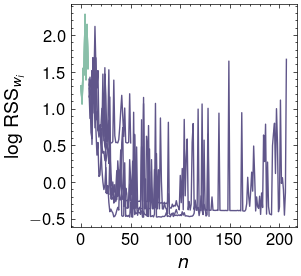

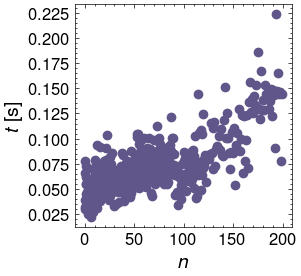

Run 1: The minimum value of the objective function in log10 scale is -0.4725
Run 1: Cumulative time for all iterations: 8.1485 seconds
Run 2: The minimum value of the objective function in log10 scale is -0.4791
Run 2: Cumulative time for all iterations: 6.0754 seconds
Run 3: The minimum value of the objective function in log10 scale is 0.5310
Run 3: Cumulative time for all iterations: 2.5763 seconds
Run 4: The minimum value of the objective function in log10 scale is -0.4802
Run 4: Cumulative time for all iterations: 3.7841 seconds
Run 5: The minimum value of the objective function in log10 scale is -0.4529
Run 5: Cumulative time for all iterations: 16.5729 seconds


In [5]:
# Prepare the figure for Objective Values
plt.figure(figsize=(3.0, 2.75), constrained_layout=True)

# Iterate over results from each run and plot
for idx, res in enumerate(results):
    objective_values = res['objective_values']
    iterations = np.arange(len(objective_values))
    neg_objective_values = -np.array(objective_values)

    # Plot initial Sobol samples
    plt.plot(
        iterations[:n_initial_points],
        neg_objective_values[:n_initial_points],
        '-', 
        markersize=6, 
        label=f'Run {idx+1} Sobol',
        color='#89BFA9'
    )

    # Plot EI samples
    plt.plot(
        iterations[n_initial_points:], 
        neg_objective_values[n_initial_points:], 
        '-', 
        markersize=6,
        label=f'Run {idx+1} logEI',
        color='#60568A'
    )

# Customize Plot Appearance
plt.xlabel('$n$', fontsize=14)                            # X-axis label
plt.ylabel('$\\log$ RSS$_{w_{i}}$', fontsize=14)           # Y-axis label
plt.xticks(fontsize=12)                                   # X-axis tick label size
plt.yticks(fontsize=12)                                   # Y-axis tick label size
#plt.legend(fontsize=10, loc="best")                       # Display legend

# Display or Save the Plot
plt.savefig("combined_fig_ei_oscillation_chia.pdf")
plt.show()

# Prepare the figure for Time per Iteration
plt.figure(figsize=(3.0, 2.75), constrained_layout=True)

# Iterate over results from each run and plot time per iteration
for idx, res in enumerate(results):
    times_per_iteration = res['times_per_iteration']
    iterations = np.arange(len(times_per_iteration))

    plt.plot(
        iterations[:len(times_per_iteration)], 
        times_per_iteration, 
        'o', 
        markersize=6, 
        label=f'Run {idx+1} Time', 
        color='#60568A'
    )

# Customize Plot Appearance
plt.xlabel('$n$', fontsize=14)                            # X-axis label
plt.ylabel('$t$ [s]', fontsize=14)                        # Y-axis label
plt.xticks(fontsize=12)                                   # X-axis tick label size
plt.yticks(fontsize=12)                                   # Y-axis tick label size
#plt.legend(fontsize=10, loc="best")                       # Display legend

# Display or Save the Time Plot
plt.savefig("combined_fig_time_per_iteration.pdf")
plt.show()

# Print Minimum Objective Values and Cumulative Time for Each Run
for idx, res in enumerate(results):
    neg_objective_values = -np.array(res['objective_values'])
    cumulative_time = res['cumulative_time']
    print(f"Run {idx + 1}: The minimum value of the objective function in log10 scale is {np.min(neg_objective_values):.4f}")
    print(f"Run {idx + 1}: Cumulative time for all iterations: {cumulative_time:.4f} seconds")


## Fitting and Visualizing the Model with Best Parameters from Bayesian Optimization

In this section, we:
1. Define the fractional model evaluator.
2. Extract and print the best parameters obtained from the Bayesian Optimization (BO) phase.
3. Fit the model using the best parameters and compute the model values.
4. Calculate the Residual Sum of Squares (RSS) for the fitted model.
5. Plot the original data, the fitted model from Bayesian Optimization, and the optimized model.


/tmp/ipykernel_46445/2007669972.py:5: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=fractional_model_name)


Best parameters from Bayesian Optimization: G = 65.264171599, V = 5.188477669, alpha = 0.786738642, beta = 0.126974904
RSS_w for the Bayesian Optimization model: 0.3309483724


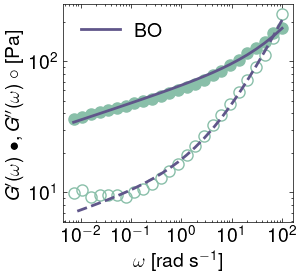

In [44]:
from cycler import cycler  # Import the cycler for customizing plot cycles

# Define model evaluator
fractional_model_name = "FractionalKelvinVoigt"
evaluator = OscillationEvaluator(model=fractional_model_name)

# Extract the best parameters from Bayesian Optimization phase
best_idx = np.argmax(best_y_samples)
best_params = best_X_samples[best_idx]
logG_best, logV_best, alpha_best, beta_best = best_params
G_best_bo = 10 ** logG_best
V_best_bo = 10 ** logV_best

# Print the best parameters from Bayesian Optimization
print("Best parameters from Bayesian Optimization: G = {:.9f}, V = {:.9f}, alpha = {:.9f}, beta = {:.9f}".format(G_best_bo, V_best_bo, alpha_best, beta_best))

# Fit the model with the best parameters from Bayesian Optimization
best_params_no_scale = G_best_bo, V_best_bo, alpha_best, beta_best
bo_model_values = evaluator.compute_model(best_params_no_scale, omega)

# Compute the RSS for the Bayesian Optimization model
rss_bo = np.sum(((G_prime - bo_model_values[0]) / G_prime) ** 2) + np.sum(((G_double_prime - bo_model_values[1]) / G_double_prime) ** 2)
print(f"RSS_w for the Bayesian Optimization model: {rss_bo:.10f}")

# Get the default color cycle
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Plot the data, the fitted model from Bayesian Optimization, and the final optimized model
plt.figure(figsize=(3.0, 2.75), constrained_layout=True)
plt.plot(omega, G_prime, 'o', markersize=8, color='#89BFA9')
plt.plot(omega, G_double_prime, 'o', color='#89BFA9', fillstyle="none", markersize=8)
plt.plot(omega, bo_model_values[0], '-', color='#60568A', lw=2, label='BO')
plt.plot(omega, bo_model_values[1], '--', color='#60568A', lw=2)

# Configure the plot
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\omega$ [rad s$^{-1}$]', fontsize=14)
plt.ylabel(r'$G^{\prime}(\omega)~\bullet, G^{\prime \prime}(\omega)~\circ$ [Pa]', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)

# Display the plot
plt.savefig("fig_bo_fit_oscillation_data_chia.pdf")
plt.show()

## Visualizing Surrogate Model Predictions for Different parameter Values

In this section, we:
1. Define a function to predict model outputs on a 2D grid of parameters.
2. Evaluate the model on a grid for various fixed beta values.
3. Create contour plots for each beta value showing the predictions of the model.
4. Identify and display the global minima for each beta value.

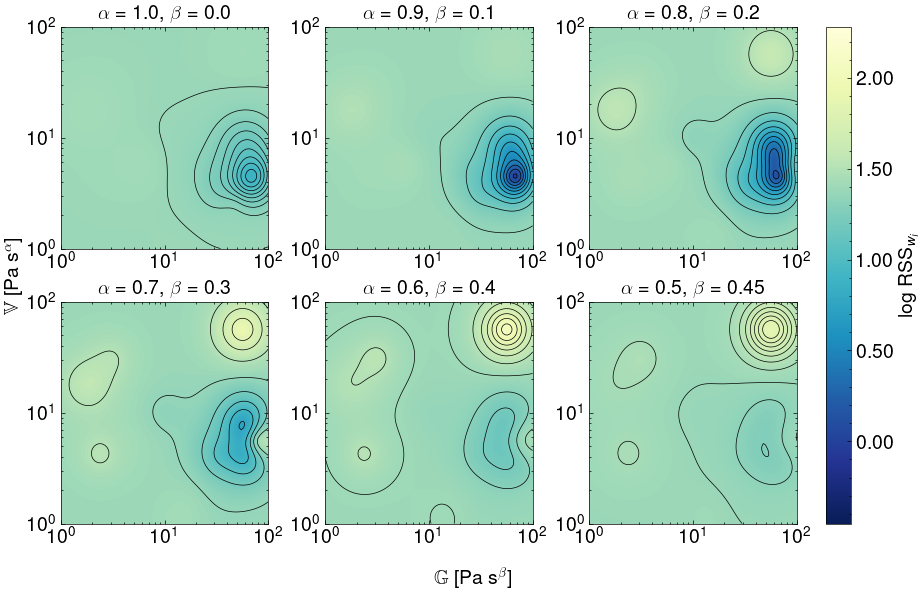

In [7]:
import matplotlib.colors as mcolors


def predict_model_on_grid_2D(model, param_space, alpha_value, beta_value, resolution=100):
    # Create a 2D mesh grid over logG and log_eta
    logG_range = torch.linspace(param_space[0, 0], param_space[0, 1], resolution)
    logV_range = torch.linspace(param_space[1, 0], param_space[1, 1], resolution)

    logG_grid, logV_grid = torch.meshgrid(logG_range, logV_range, indexing="ij")
    alpha_grid = torch.full_like(logG_grid, alpha_value) # keep alpha fixed
    beta_grid = torch.full_like(logG_grid, beta_value) # keep beta fixed

    param_grid = torch.stack([logG_grid.reshape(-1), logV_grid.reshape(-1), alpha_grid.reshape(-1), beta_grid.reshape(-1)], dim=-1)

    # Predict using the trained model
    with torch.no_grad():
        preds_1 = model.posterior(param_grid).mean.numpy().reshape(logG_grid.shape)

    return logG_grid, logV_grid, preds_1

# Define specific (alpha, beta) pairs to plot.
alpha_beta_pairs = [
(1.0, 0.0),
(0.90, 0.1),
(0.80, 0.2),
(0.7, 0.3),
(0.6, 0.4),
(0.50, 0.45)
]

resolution = 100

# Ensure these values are correctly calculated
min_val, max_val = (-max(objective_values), -min(objective_values))

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(9, 5.5), constrained_layout=True)
contours_list = []

global_minima = []  # To store global minima parameters

for ax, (alpha, beta) in zip(axes.flatten(), alpha_beta_pairs):
    logG_grid, logV_grid, preds_obj1 = predict_model_on_grid_2D(best_model, param_space, alpha, beta, resolution)
    
    # Convert logG and logV to G and V
    G = 10 ** logG_grid.numpy()
    V = 10 ** logV_grid.numpy()

    # Take negative predictions because of the sign inversion
    neg_preds_obj1 = -1 * scaler.inverse_transform(preds_obj1)
    
    # Find global minima
    min_index = np.unravel_index(neg_preds_obj1.argmin(), neg_preds_obj1.shape)
    global_min_logG = logG_grid[min_index]
    global_min_logV = logV_grid[min_index]
    global_min_G = 10**global_min_logG
    global_min_V = 10**global_min_logV
    global_min_value = neg_preds_obj1[min_index]
    global_minima.append((global_min_G.item(), global_min_V.item(), 10**global_min_value))
    
    # Create the 2D contour plot for Objective 1
    contour = ax.contourf(G, V, neg_preds_obj1, levels=100, vmin=min_val, vmax=max_val, cmap='YlGnBu_r')
    contours_list.append(contour)
    ax.contour(G, V, neg_preds_obj1, levels=10, colors='black', linewidths=0.5)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_title(f'$\\alpha$ = {alpha}, $\\beta$ = {beta}', fontsize=14)

# Create a ScalarMappable with the same colormap and normalization
norm = mcolors.Normalize(vmin=min_val, vmax=max_val)
sm = plt.cm.ScalarMappable(cmap='YlGnBu_r', norm=norm)
sm.set_array([])  # Only needed for ScalarMappable

# Add a single colorbar for all subplots
cbar = fig.colorbar(sm, ax=axes, location='right', aspect=20, pad=0.02, format='%.2f')
cbar.set_label('$\\log$ RSS$_{w_{i}}$', fontsize=14)
cbar.ax.tick_params(labelsize=14)

# Add common labels
fig.text(0.5, -0.05, '$\mathbb{G}$ [Pa s$^{\\beta}$]', ha='center', va='center', fontsize=14)
fig.text(-0.01, 0.5, '$\mathbb{V}$ [Pa s$^{\\alpha}$]', ha='center', va='center', rotation='vertical', fontsize=14)

# Save the plot and show
plt.savefig("fig_obj1_oscillation_chia.pdf")
plt.show()

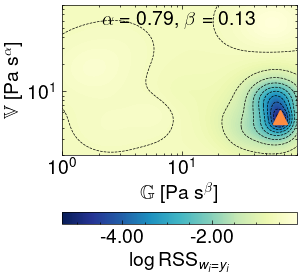

In [45]:
import matplotlib.colors as mcolors

def predict_model_mean_on_grid_2D(model, param_space, alpha_value, beta_value, resolution=100):
    # Create a 2D mesh grid over logG and log_eta
    logG_range = torch.linspace(param_space[0, 0], param_space[0, 1], resolution)
    logV_range = torch.linspace(param_space[1, 0], param_space[1, 1], resolution)

    logG_grid, logV_grid = torch.meshgrid(logG_range, logV_range, indexing="ij")
    alpha_grid = torch.full_like(logG_grid, alpha_value) # keep alpha fixed
    beta_grid = torch.full_like(logG_grid, beta_value) # keep beta fixed

    param_grid = torch.stack([logG_grid.reshape(-1), logV_grid.reshape(-1), alpha_grid.reshape(-1), beta_grid.reshape(-1)], dim=-1)

    # Predict using the trained model
    with torch.no_grad():
        preds_mean = model.posterior(param_grid).mean.numpy().reshape(logG_grid.shape)

    return logG_grid, logV_grid, preds_mean

alpha = alpha_best
beta = beta_best
resolution = 100

# Plotting
plt.figure(figsize=(3, 2.75), constrained_layout=True)

logG_grid, logV_grid, preds_obj_mean = predict_model_mean_on_grid_2D(best_model, param_space, alpha, beta, resolution)

# Min/Max values for color scaling
min_val, max_val = (-np.max(preds_obj_mean), -np.min(preds_obj_mean))

# Convert logG and logV to G and V
G = 10 ** logG_grid.numpy()
V = 10 ** logV_grid.numpy()

# Inverting predictions
neg_preds_obj_mean = -1 * preds_obj_mean  # Apply your scaler if needed

# 2D contour plot
contour = plt.contourf(G, V, neg_preds_obj_mean, levels=100, vmin=min_val, vmax=max_val, cmap='YlGnBu_r')
plt.contour(G, V, neg_preds_obj_mean, levels=10, colors='black', linewidths=0.5)
plt.plot(65.26, 5.19, "^", color="#FF8C42", ms=10)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1, 90)
plt.ylim(2, 90)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('$\mathbb{G}$ [Pa s$^{\\beta}$]', fontsize=14)
plt.ylabel('$\mathbb{V}$ [Pa s$^{\\alpha}$]', fontsize=14)

# Title inside the plot
plt.text(0.5, 0.9, r'$\alpha = 0.79$, $\beta = 0.13$', 
         fontsize=14, ha='center', va='center', color='black', 
         transform=plt.gca().transAxes)

# Colorbar
norm = mcolors.Normalize(vmin=min_val, vmax=max_val)
sm = plt.cm.ScalarMappable(cmap='YlGnBu_r', norm=norm)
sm.set_array([])

# Corrected colorbar axis
cbar = plt.colorbar(sm, ax=plt.gca(), location='bottom', aspect=20, pad=0.05, format='%.2f')
cbar.set_label('$\log{{\\rm{RSS}}_{w_{i}=y_{i}}}$', fontsize=14)
cbar.ax.tick_params(labelsize=14)
#cbar.ax.invert_xaxis()

# Save and display
plt.savefig("fig_obj1_oscillation_chia_solution_mean.pdf")
plt.show()

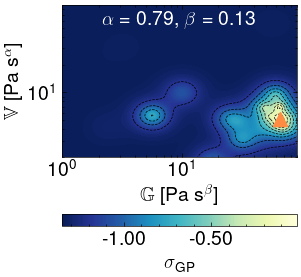

In [46]:
import matplotlib.colors as mcolors

def predict_model_std_on_grid_2D(model, param_space, alpha_value, beta_value, resolution=100):
    # Create a 2D mesh grid over logG and log_eta
    logG_range = torch.linspace(param_space[0, 0], param_space[0, 1], resolution)
    logV_range = torch.linspace(param_space[1, 0], param_space[1, 1], resolution)

    logG_grid, logV_grid = torch.meshgrid(logG_range, logV_range, indexing="ij")
    alpha_grid = torch.full_like(logG_grid, alpha_value) # keep alpha fixed
    beta_grid = torch.full_like(logG_grid, beta_value) # keep beta fixed

    param_grid = torch.stack([logG_grid.reshape(-1), logV_grid.reshape(-1), alpha_grid.reshape(-1), beta_grid.reshape(-1)], dim=-1)

    # Predict using the trained model
    with torch.no_grad():
        preds_std = model.posterior(param_grid).variance.sqrt().numpy().reshape(logG_grid.shape)

    return logG_grid, logV_grid, preds_std

alpha = alpha_best
beta = beta_best
resolution = 100

# Plotting
plt.figure(figsize=(3, 2.75), constrained_layout=True)

logG_grid, logV_grid, preds_obj_std = predict_model_std_on_grid_2D(best_model, param_space, alpha, beta, resolution)

# Min/Max values for color scaling
min_val, max_val = (-np.max(preds_obj_std), -np.min(preds_obj_std))

# Convert logG and logV to G and V
G = 10 ** logG_grid.numpy()
V = 10 ** logV_grid.numpy()

# Inverting predictions
neg_preds_obj_std = -1 * preds_obj_std  # Apply your scaler if needed

# 2D contour plot
contour = plt.contourf(G, V, neg_preds_obj_std, levels=100, vmin=min_val, vmax=max_val, cmap='YlGnBu_r')
plt.contour(G, V, neg_preds_obj_std, levels=10, colors='black', linewidths=0.5)
plt.plot(65.26, 5.19, "^", color="#FF8C42", ms=10)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1, 90)
plt.ylim(2, 90)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('$\mathbb{G}$ [Pa s$^{\\beta}$]', fontsize=14)
plt.ylabel('$\mathbb{V}$ [Pa s$^{\\alpha}$]', fontsize=14)

# Title inside the plot
plt.text(0.5, 0.9, r'$\alpha = 0.79$, $\beta = 0.13$', 
         fontsize=14, ha='center', va='center', color='white', 
         transform=plt.gca().transAxes)

# Colorbar
norm = mcolors.Normalize(vmin=min_val, vmax=max_val)
sm = plt.cm.ScalarMappable(cmap='YlGnBu_r', norm=norm)
sm.set_array([])

# Corrected colorbar axis
cbar = plt.colorbar(sm, ax=plt.gca(), location='bottom', aspect=20, pad=0.05, format='%.2f')
cbar.set_label('$\sigma_{\\rm{GP}}$', fontsize=14)
cbar.ax.tick_params(labelsize=14)
#cbar.ax.invert_xaxis()

# Save and display
plt.savefig("fig_obj1_oscillation_chia_solution_std.pdf")
plt.show()

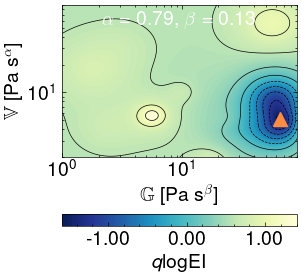

In [47]:
import matplotlib.colors as mcolors

def compute_logei_grid(model, param_space, alpha_value, beta_value, best_f, resolution=100):
    # Create a 2D mesh grid over logG and log_eta
    logG_range = torch.linspace(param_space[0, 0], param_space[0, 1], resolution)
    logV_range = torch.linspace(param_space[1, 0], param_space[1, 1], resolution)

    logG_grid, logV_grid = torch.meshgrid(logG_range, logV_range, indexing="ij")
    alpha_grid = torch.full_like(logG_grid, alpha_value) # keep alpha fixed
    beta_grid = torch.full_like(logG_grid, beta_value) # keep beta fixed

    param_grid = torch.stack([logG_grid.reshape(-1), logV_grid.reshape(-1), alpha_grid.reshape(-1), beta_grid.reshape(-1)], dim=-1)

    acq_func = qLogExpectedImprovement(
        model=model,
        best_f=best_f
    )

    # Reshape for batched qEI input: [N, q=1, d]
    param_grid_q = param_grid.unsqueeze(1)

    with torch.no_grad():
        ei_vals = acq_func(param_grid_q).squeeze().numpy().reshape(logG_grid.shape)

    return logG_grid, logV_grid, ei_vals


alpha = alpha_best
beta = beta_best
resolution = 100
best_f = best_y_samples.max()  # If your objective values are stored in train_y


# Plotting
plt.figure(figsize=(3, 2.75), constrained_layout=True)

logG_grid, logV_grid, preds_obj_std = compute_logei_grid(best_model, param_space, alpha, beta, best_f, resolution)

# Min/Max values for color scaling
min_val, max_val = (-np.max(preds_obj_std), -np.min(preds_obj_std))

# Convert logG and logV to G and V
G = 10 ** logG_grid.numpy()
V = 10 ** logV_grid.numpy()

# Inverting predictions
neg_preds_obj_std = -1 * preds_obj_std  # Apply your scaler if needed

# 2D contour plot
contour = plt.contourf(G, V, neg_preds_obj_std, levels=100, vmin=min_val, vmax=max_val, cmap='YlGnBu_r')
plt.contour(G, V, neg_preds_obj_std, levels=10, colors='black', linewidths=0.5)
plt.plot(65.26, 5.19, "^", color="#FF8C42", ms=10)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1, 90)
plt.ylim(2, 90)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('$\mathbb{G}$ [Pa s$^{\\beta}$]', fontsize=14)
plt.ylabel('$\mathbb{V}$ [Pa s$^{\\alpha}$]', fontsize=14)

# Title inside the plot
plt.text(0.5, 0.9, r'$\alpha = 0.79$, $\beta = 0.13$', 
         fontsize=14, ha='center', va='center', color='white', 
         transform=plt.gca().transAxes)

# Colorbar
norm = mcolors.Normalize(vmin=min_val, vmax=max_val)
sm = plt.cm.ScalarMappable(cmap='YlGnBu_r', norm=norm)
sm.set_array([])

# Corrected colorbar axis
cbar = plt.colorbar(sm, ax=plt.gca(), location='bottom', aspect=20, pad=0.05, format='%.2f')
cbar.set_label('$q$logEI', fontsize=14)
cbar.ax.tick_params(labelsize=14)
#cbar.ax.invert_xaxis()

# Save and display
plt.savefig("fig_obj1_oscillation_chia_solution_qei.pdf")
plt.show()

In [10]:
# Objective function to minimize (RRS weighted by true values)
def objective_minimize(params, omega, G_prime, G_double_prime):
    logG, logV, alpha, beta = params
    G = 10 ** logG
    V = 10 ** logV
    params_no_scale = G, V, alpha, beta
    model = "FractionalKelvinVoigt"
    evaluator = OscillationEvaluator(model=model)
    
    # Compute oscillation data
    model_values = evaluator.compute_model(params_no_scale, omega)
    
    # Add noise
    error = createRandomError(omega.shape[0], 0.0)
    model_values_noisy = np.multiply(model_values, error)
    
    # Define objective function: sum of squared relative errors for G' and G''
    obj1 = np.sum(((G_prime - model_values_noisy[0]) / G_prime) ** 2) + np.sum(((G_double_prime - model_values_noisy[1]) / G_double_prime) ** 2)
    
    return obj1  # Return the raw error (we no longer need the -log10)

def callback(params):
    obj_value = objective_minimize(params, omega, G_prime, G_double_prime)
    current_errors.append(obj_value)

In [11]:
import numpy as np
from scipy.optimize import minimize

custom_bounds = [(low, high) if i < 2 else (low, high) for i, (low, high) in enumerate(param_space)]


np.random.seed(42)
initial_guesses = np.random.uniform(param_space[:, 0], param_space[:, 1], (5, 4))
initial_guesses_list = initial_guesses.tolist()

# Define lists to store optimization results and errors
all_errors = []
results_spy = []

# List of optimization methods to try
methods = ['Nelder-Mead']

start_time_NM = timer.time()

for method in methods:
    print(f"Running optimization with method: {method}")
    for initial_guess in initial_guesses_list:
        current_errors = []
        
        # Adjust options based on the method
        options = {'disp': True, 'maxiter': 1000}
        if method == 'Nelder-Mead':
            options.update({'xatol': 1e-9, 'fatol': 1e-9, 'maxfev': 2000})
        elif method in ['L-BFGS-B', 'TNC', 'SLSQP']:
            options.update({'ftol': 1e-9})

        # Bounds are only passed if the method supports them
        bounds = custom_bounds if method in ['L-BFGS-B', 'TNC', 'SLSQP', 'Powell'] else None
        
        res = minimize(
            objective_minimize,
            initial_guess,
            args=(omega, G_prime, G_double_prime),
            method=method,
            bounds=bounds,
            callback=callback if method != 'TNC' else None,  # TNC does not support callback
            options=options
        )
        
        results_spy.append({'method': method, 'result': res})
        all_errors.append({'method': method, 'errors': current_errors})

final_time_NM = timer.time() - start_time_NM 

# Printing the cumulative time
print(f"Final time for all iterations: {final_time_NM:.4f} seconds")

# Extracting function values and optimized parameters
function_values = [res['result'].fun for res in results_spy]
optimized_parameters = [res['result'].x for res in results_spy]

Running optimization with method: Nelder-Mead
Optimization terminated successfully.
         Current function value: 0.329764
         Iterations: 231
         Function evaluations: 416
Optimization terminated successfully.
         Current function value: 0.329764
         Iterations: 404
         Function evaluations: 704
Optimization terminated successfully.
         Current function value: 0.329764
         Iterations: 234
         Function evaluations: 417
Optimization terminated successfully.
         Current function value: 0.329764
         Iterations: 218
         Function evaluations: 386
Optimization terminated successfully.
         Current function value: 0.329764
         Iterations: 389
         Function evaluations: 681
Final time for all iterations: 0.1344 seconds


/tmp/ipykernel_46445/1559105254.py:8: DeprecationWarning: OscillationEvaluator will be deprecated and will be removed in future versions. Please use SAOSEvaluator instead.
  evaluator = OscillationEvaluator(model=model)


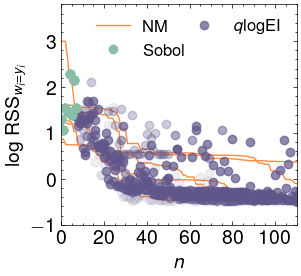

In [12]:
# Filter errors by method
nm_errors = [err['errors'] for err in all_errors if err['method'] == 'Nelder-Mead']
powell_errors = [err['errors'] for err in all_errors if err['method'] == 'Powell']
lbfgsb_errors = [err['errors'] for err in all_errors if err['method'] == 'L-BFGS-B']

# Configure the Figure
plt.figure(figsize=(3, 2.75), constrained_layout=True)

# Plot errors for Nelder-Mead runs
for i, error_list in enumerate(nm_errors):
    plt.plot(
        np.log10(error_list), 
        '-', 
        markersize=4,
        color='#FF8C42',               # Orange for Nelder-Mead
        label='NM' if i == 0 else ""  # Label only the first run
    )

# Iterate over results from each run and plot
for idx, res in enumerate(results):
    objective_values = res['objective_values']
    iterations = np.arange(len(objective_values))
    neg_objective_values = -np.array(objective_values)

    # Plot initial Sobol samples
    plt.plot(
        iterations[:n_initial_points],
        neg_objective_values[:n_initial_points],
        'o', 
        markersize=6, 
        label='Sobol' if idx == 0 else "",  # Label only the first run
        color='#89BFA9'
    )

    # Plot EI samples
    plt.plot(
        iterations[n_initial_points:], 
        neg_objective_values[n_initial_points:], 
        "o",
        markersize=6, alpha=0.7 - 0.2 * (idx % 4),
        label='$q$logEI' if idx == 0 else "", 
        color='#60568A'
    )



# Customize Plot Appearance
plt.xlim(0, 110)                                          # Set x-axis limit
plt.ylim(-1, 3.8)                                        # Uncomment and set y-axis limit if needed
plt.xlabel('$n$', fontsize=14)                            # X-axis label
plt.ylabel('$\\log$ RSS$_{w_{i}=y_{i}}$', fontsize=14)           # Y-axis label
plt.xticks(fontsize=14)                                   # X-axis tick label size
plt.yticks(fontsize=14)                                   # Y-axis tick label size
plt.legend(fontsize=12, loc="upper right", ncols=2, columnspacing=0.1, 
           #bbox_to_anchor=(1.05, 1)
          )                       # Display legend

# Display the Plot
plt.savefig("fig_ei_oscillation_chia_comparison.pdf")                    # Uncomment to save the plot
plt.show()

Best Nelder-Mead Parameters: [1.81462837 0.70404738 0.79522201 0.12782203]
Best Nelder-Mead Function Value: 0.3297641766720009


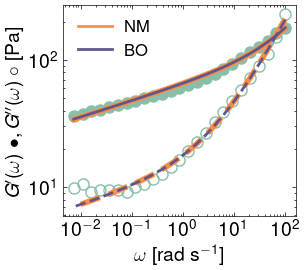

In [13]:
import matplotlib.lines as mlines


# Find the best results for Nelder-Mead and L-BFGS-B
nm_results = [res['result'] for res in results_spy if res['method'] == 'Nelder-Mead']
#lbfgsb_results = [res['result'] for res in results if res['method'] == 'L-BFGS-B']

# Identify the best (lowest function value) result for each method
best_nm_result = min(nm_results, key=lambda r: r.fun)
#best_lbfgsb_result = min(lbfgsb_results, key=lambda r: r.fun)

# Extract optimized parameters and function values
best_nm_params = best_nm_result.x
#best_lbfgsb_params = best_lbfgsb_result.x

best_nm_value = best_nm_result.fun
#best_lbfgsb_value = best_lbfgsb_result.fun

# Print best results
print("Best Nelder-Mead Parameters:", best_nm_params)
print("Best Nelder-Mead Function Value:", best_nm_value)

#print("Best L-BFGS-B Parameters:", best_lbfgsb_params)
#print("Best L-BFGS-B Function Value:", best_lbfgsb_value)

# Compute model outputs for both best parameter sets
nm_model_values = evaluator.compute_model(
    (10**best_nm_params[0], 10**best_nm_params[1], best_nm_params[2], best_nm_params[3]), omega
)
#lbfgsb_model_values = evaluator.compute_model(
#    (10**best_lbfgsb_params[0], 10**best_lbfgsb_params[1], best_lbfgsb_params[2], best_lbfgsb_params[3]), omega
#)

# Separate G' and G'' values from model outputs
nm_G_prime, nm_G_double_prime = nm_model_values
#lbfgsb_G_prime, lbfgsb_G_double_prime = lbfgsb_model_values

# Plot the data
plt.figure(figsize=(3, 2.75))

# Experimental data
plt.plot(omega, G_prime, 'o', markersize=8, color='#89BFA9')
plt.plot(omega, G_double_prime, 'o', color='#89BFA9', fillstyle="none", markersize=8)

# Nelder-Mead solution
plt.plot(omega, nm_G_prime, '-', color='#FF8C42', lw=4, label='NM')
plt.plot(omega, nm_G_double_prime, '--', color='#FF8C42', lw=4)

# L-BFGS-B solution
#plt.plot(omega, lbfgsb_G_prime, '-', color='#1F77B4', lw=2, label='L-BFGS-B')
#plt.plot(omega, lbfgsb_G_double_prime, '--', color='#1F77B4', lw=2)

# BO solution
plt.plot(omega, bo_model_values[0], '-', color='#60568A', lw=2, label='BO')
plt.plot(omega, bo_model_values[1], '--', color='#60568A', lw=2)


# Configure the plot
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\omega$ [rad s$^{-1}$]', fontsize=14)
plt.ylabel(r'$G^{\prime}(\omega)~\bullet, G^{\prime \prime}(\omega)~\circ$ [Pa]', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(fontsize=12)

# Create custom legend handles with matching line thickness
nm_handle = mlines.Line2D([], [], color='#FF8C42', lw=2, label='NM')  # Adjusted lw to 2
bo_handle = mlines.Line2D([], [], color='#60568A', lw=2, label='BO')

# Add legend with custom handles
plt.legend(handles=[nm_handle, bo_handle], fontsize=12)

#plt.tight_layout()
plt.savefig("fig_bo_fit_oscillation_data_chia_comparison.pdf")
plt.show()